In [1]:
import sys, os
sys.path.append(os.curdir)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
# 윈도우에서 matplotlib에 한글을 지원해준다. linux는 모르겠다.
font = {'family' : 'Malgun_Gothic', 'size' : 15}
matplotlib.rc('font', **font)

In [2]:
import warnings
warnings.filterwarnings('ignore')
# 버전 차이로 인해 출력되는 에러 문구 등을 무시. filterwarnings를 통해 특정 타입의 에러를 무시할 수 있다.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# 시각화한 그래프 내의 글자를 꽤 선명하게 출력해준다. 
matplotlib.rc('axes', unicode_minus=False)
# 이 명령이 없으면 그래프에서 마이너스가 ㅁ으로 출력된다. 즉 그래프에서 마이너스기호'-'를 표기하기 위함이다.
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
# pandas의 DataFrame의 행과 열을 최대 몇개까지 출력할지를 설정한다. '...'으로 생략된 부분을 볼 수 있다.

COLOR = 'GRAY'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
#jupyter notebook의 테마가 블랙이면 글씨가 안 보여서 GRAY컬러로 지정했다.

## Step0. Problem Definition
타이타닉 호에서 탑승했던 사람들의 정보를 바탕으로 생존자를 예측하는 문제이다. <br>
이 문제를 풀기 위해서, 여러 가지 머신러닝 스킬들을 사용해야 할 것이다.

## Step1. Data Acquiring

In [3]:
train = pd.read_csv('train.csv', index_col='PassengerId')

In [4]:
test = pd.read_csv('test.csv')

In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Step2. Exploratory Data Analysis(탐색적 데이터 분석
데이터는 실무의 경우 직접 크롤링을 하거나 데이터에 상응하는 비용을 지불하여 구해야한다. 타이타닉 데이터는 캐글에서 다운 받아 사용할 수 있다.

In [6]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Data Dictionary
- Survived : 0 = No, 1 = Yes
- Pclass : Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- SibSp : # of siblings or spouses aboard the Titanic
- Parch : # of parents or childrens aboard the Titanic
- Ticket : Ticket number
- Cabin : Cabin number
- Embarked : Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


float type 2개 : Age, Fare  <br>
int type 4개 : Survived,  Pclass, SibSp, Parch<br>
object(string) type 5개 : Name, Sex, Ticket, Cabin, Embarked

In [8]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Age는 약 20%가 null이다. Embarked는 전체에서 2개만 null이다. <br>
Cabin은 약 77%가 null이다.<br>
Age와 Embarked는 데이터를 채우고  Cabin은 null이 과반수이며 string type이기때문에 규칙을 찾기 어려워보이므로 제외한다.

In [9]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


findfont: Font family ['Malgun_Gothic'] not found. Falling back to DejaVu Sans.


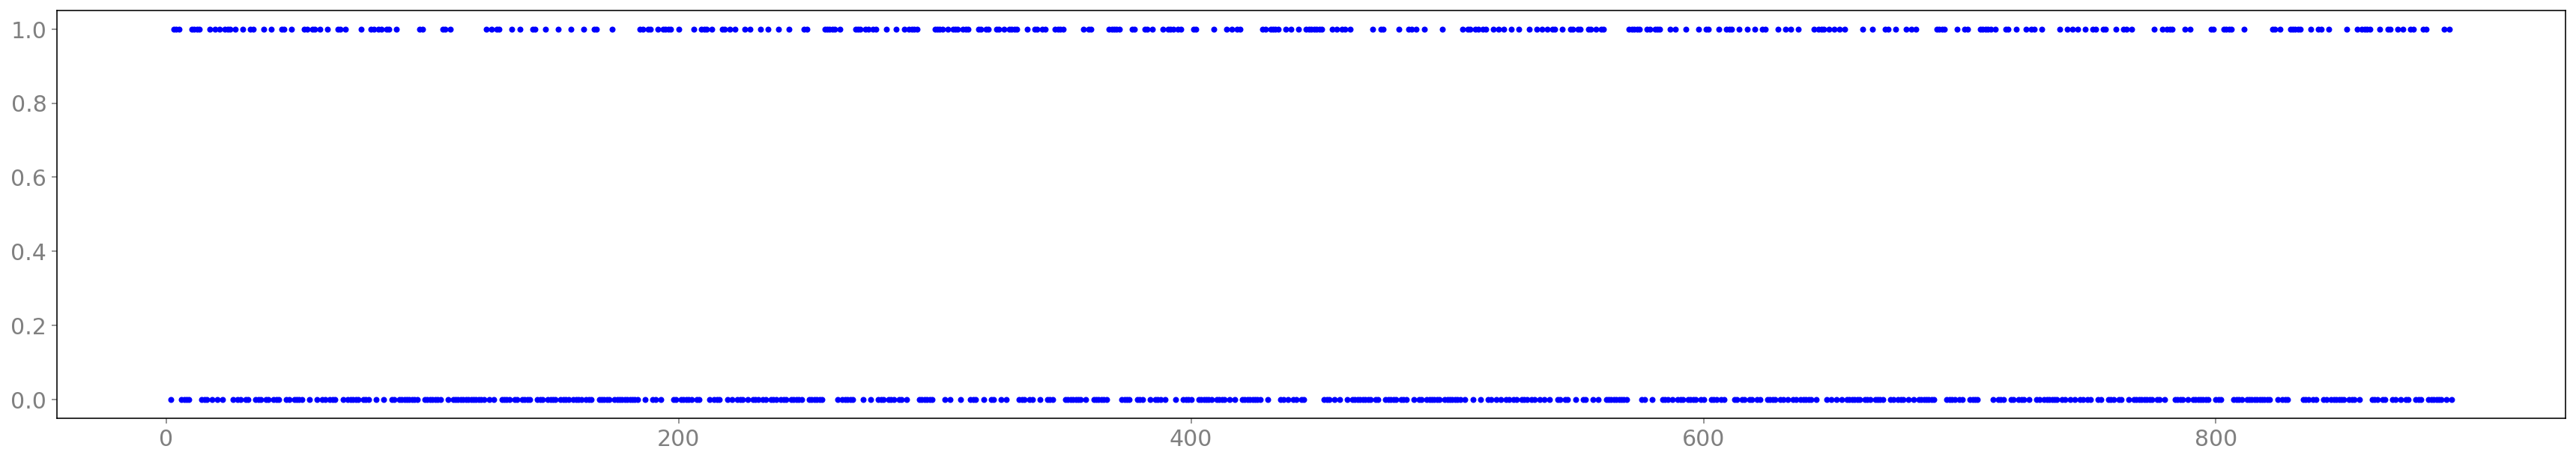

In [10]:
plt.figure(figsize=(30, 5))
plt.plot(train.index + 1, train['Survived'], 'b.')
plt.show()

Dirichlet function도 아니고... PassengerId와 Survived와의 상관관계는 없다고 강하게 확신한다. <br>
PassengerId는 Name에 무작위로 부여된 것일테니 Named과 Survived와의 상관관계도 없다고 할 수 있겠다. 이름에서 title만을 추출하여 활용할 수 있다고는 하지만, 사견으로서, 복잡하게 최적화(Mr. Miss. Mrs. 이외에 종류가 너무 많다)하기보다는 단순한게 좋을 것 같다.

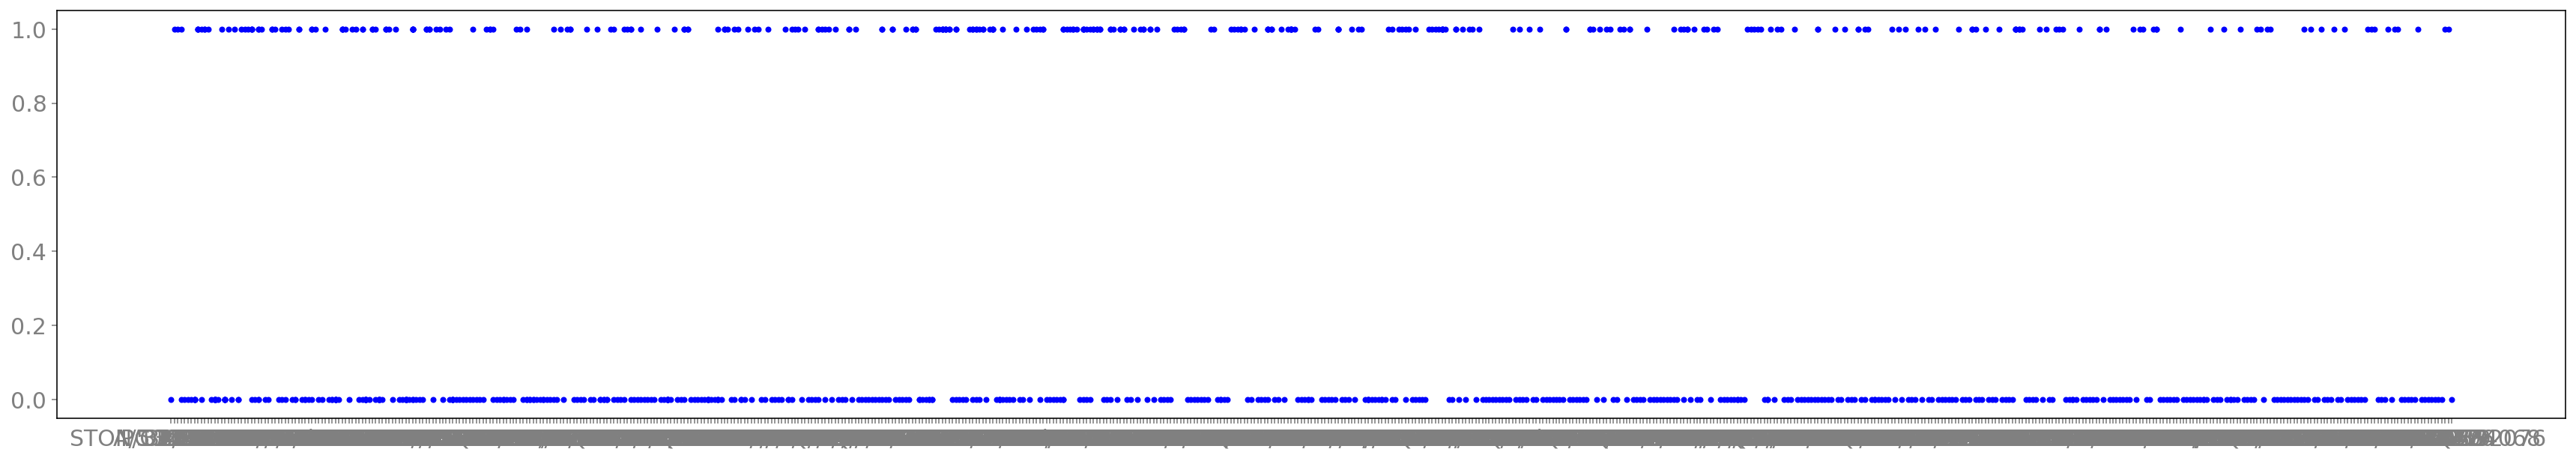

In [11]:
plt.figure(figsize=(30, 5))
plt.plot(train['Ticket'], train['Survived'], 'b.')
plt.show()

Ticket의 번호가 규칙성을 가지고 있을지 몰라도 적어도 번호가 크거나 작거나해서 생존률이 높거나 낮지는 않다. Ticket의 규칙을 찾기는 어려워 보인다(이는 나의 도메인 지식의 한계일 수 있다).

In [12]:
def bar_chart(data, feature):
    survived = data[data['Survived']==1][feature].value_counts()
    dead = data[data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(10,10))

In [13]:
def hue_chart(data, feature):
    figure, axes = plt.subplots(nrows=1, ncols=2)
    figure.set_size_inches(20, 10)
    sn.countplot(data=data, x=feature, ax=axes[0])
    sn.countplot(data=data, x=feature, hue='Survived', ax=axes[1])

In [14]:
def pie_chart(data, feature):
    feature_ratio = data[feature].value_counts(sort=False)#.sort_index()
    feature_size = feature_ratio.size
    feature_index = feature_ratio.index
    survived = data['Survived'].eq(1).groupby(data[feature]).sum()
    dead = data['Survived'].eq(0).groupby(data[feature]).sum()#.sort_index()
    
    plt.figure(figsize=(10,10))
    plt.plot(aspect='auto')
    plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
    plt.title(feature + '\'s ratio in total')
    plt.show()
    
    f, axs = plt.subplots(1, len(feature_index), figsize=(18, 18))
    for i, index in enumerate(feature_index):
        plt.subplot(1, feature_size, i+1, aspect='equal')
        plt.pie(x=[survived[index], dead[index]], labels=['Survived', 'Dead'], autopct='%1.1f%%')
        plt.title(str(index)+'\'s ratio')

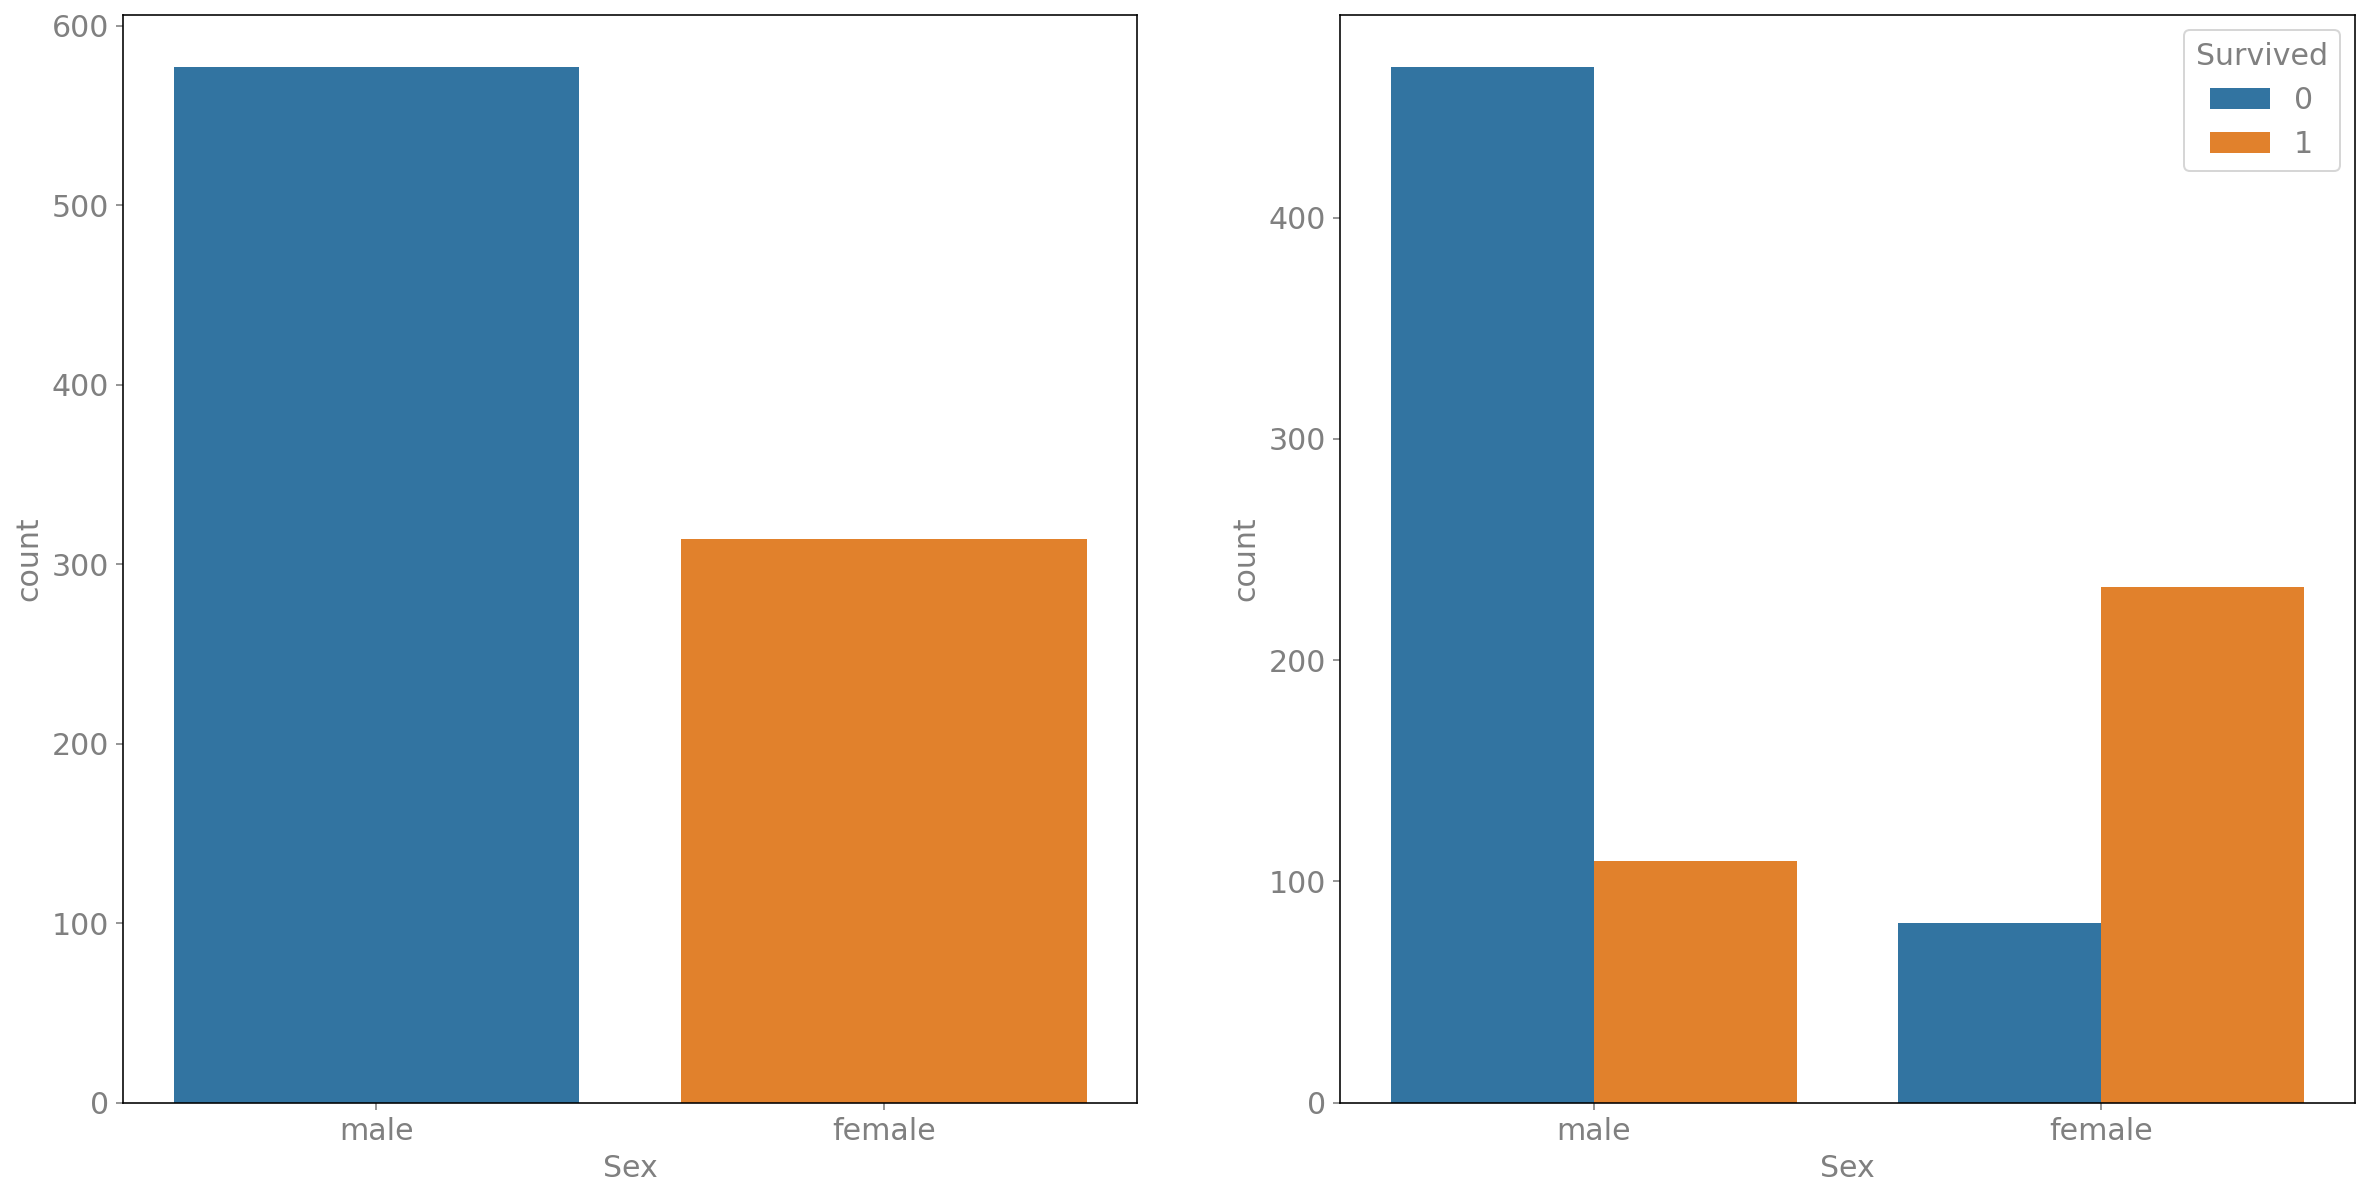

In [15]:
hue_chart(train, 'Sex')

findfont: Font family ['Malgun_Gothic'] not found. Falling back to DejaVu Sans.


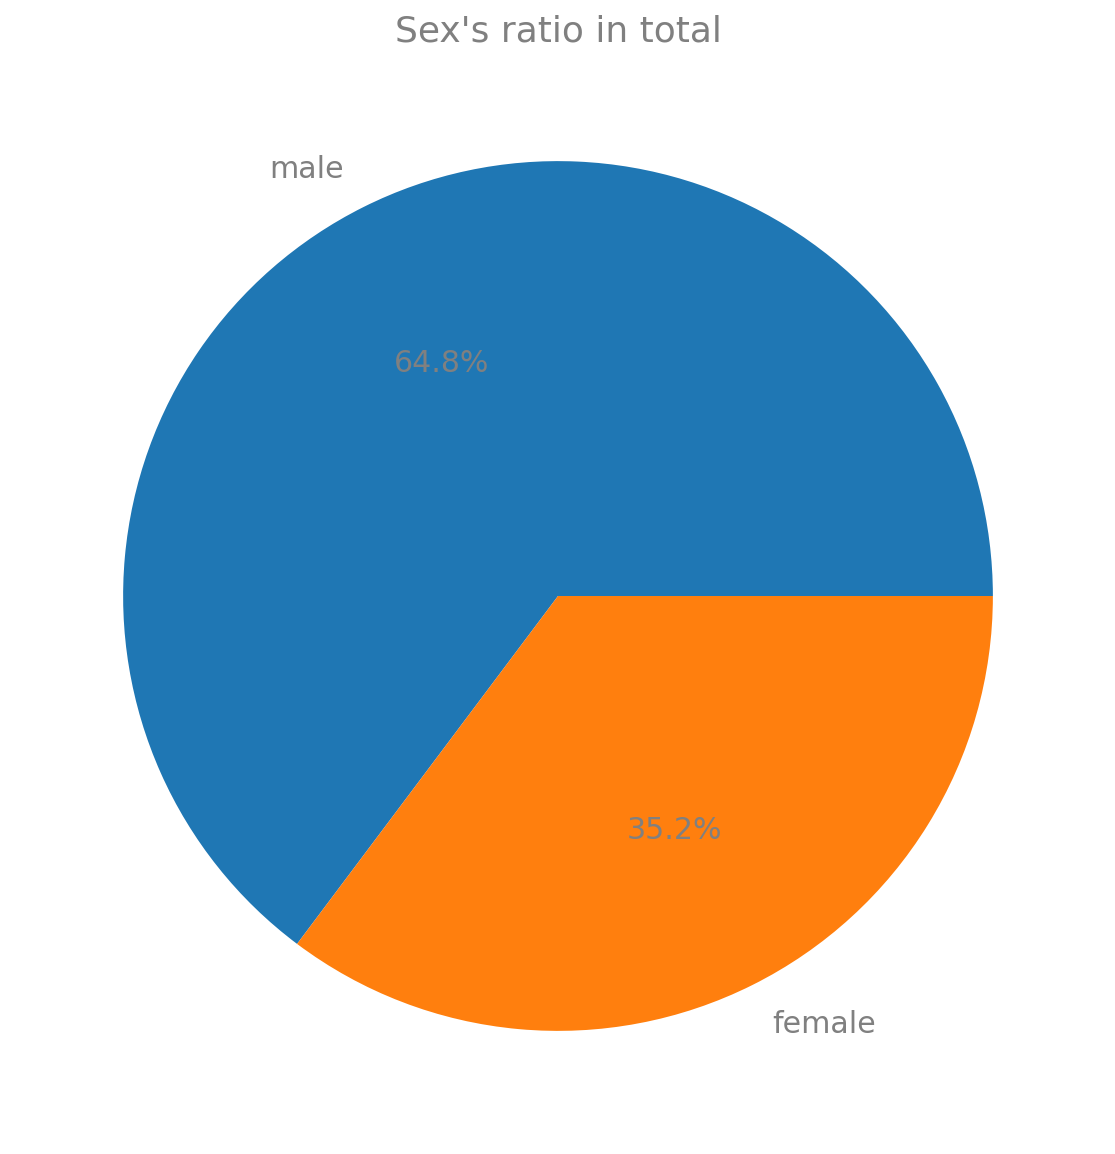

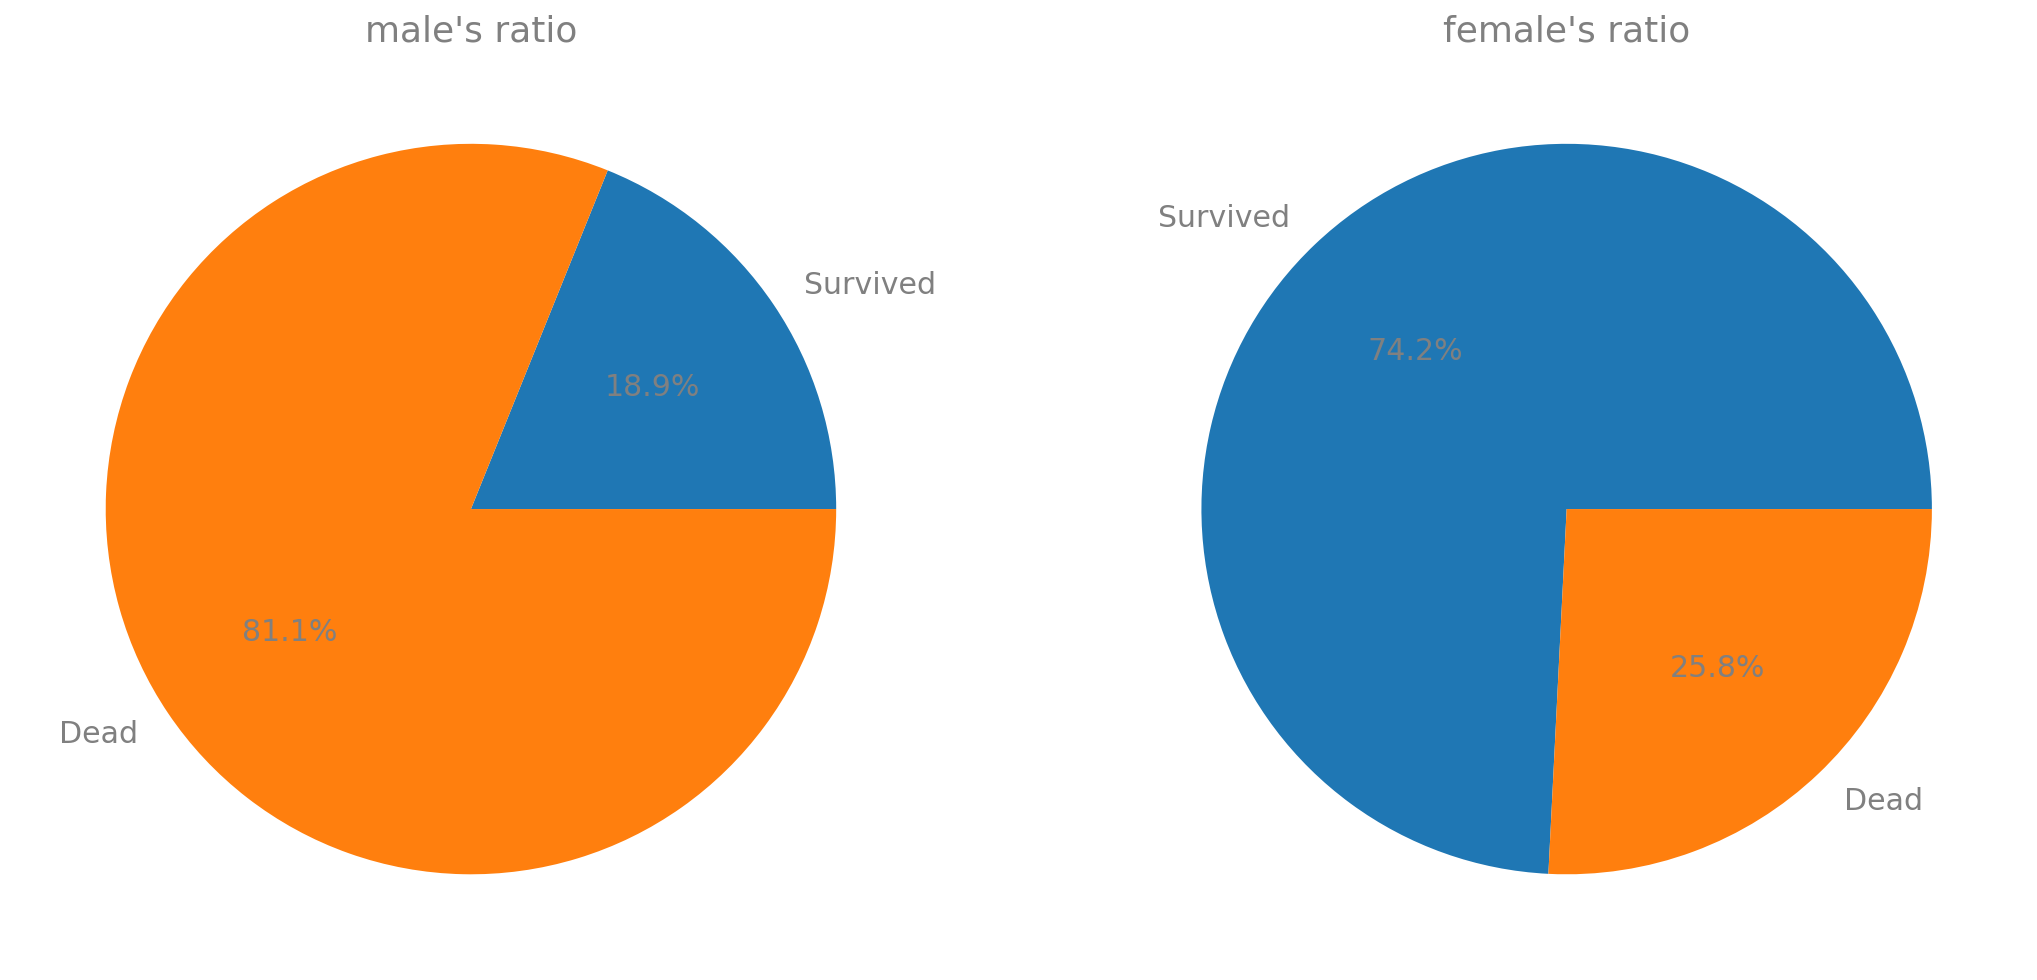

In [16]:
pie_chart(train, 'Sex')

In [17]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

결론 : 남성이 여성보다 약 2배 많지만 생존률은 여성이 더 높다.

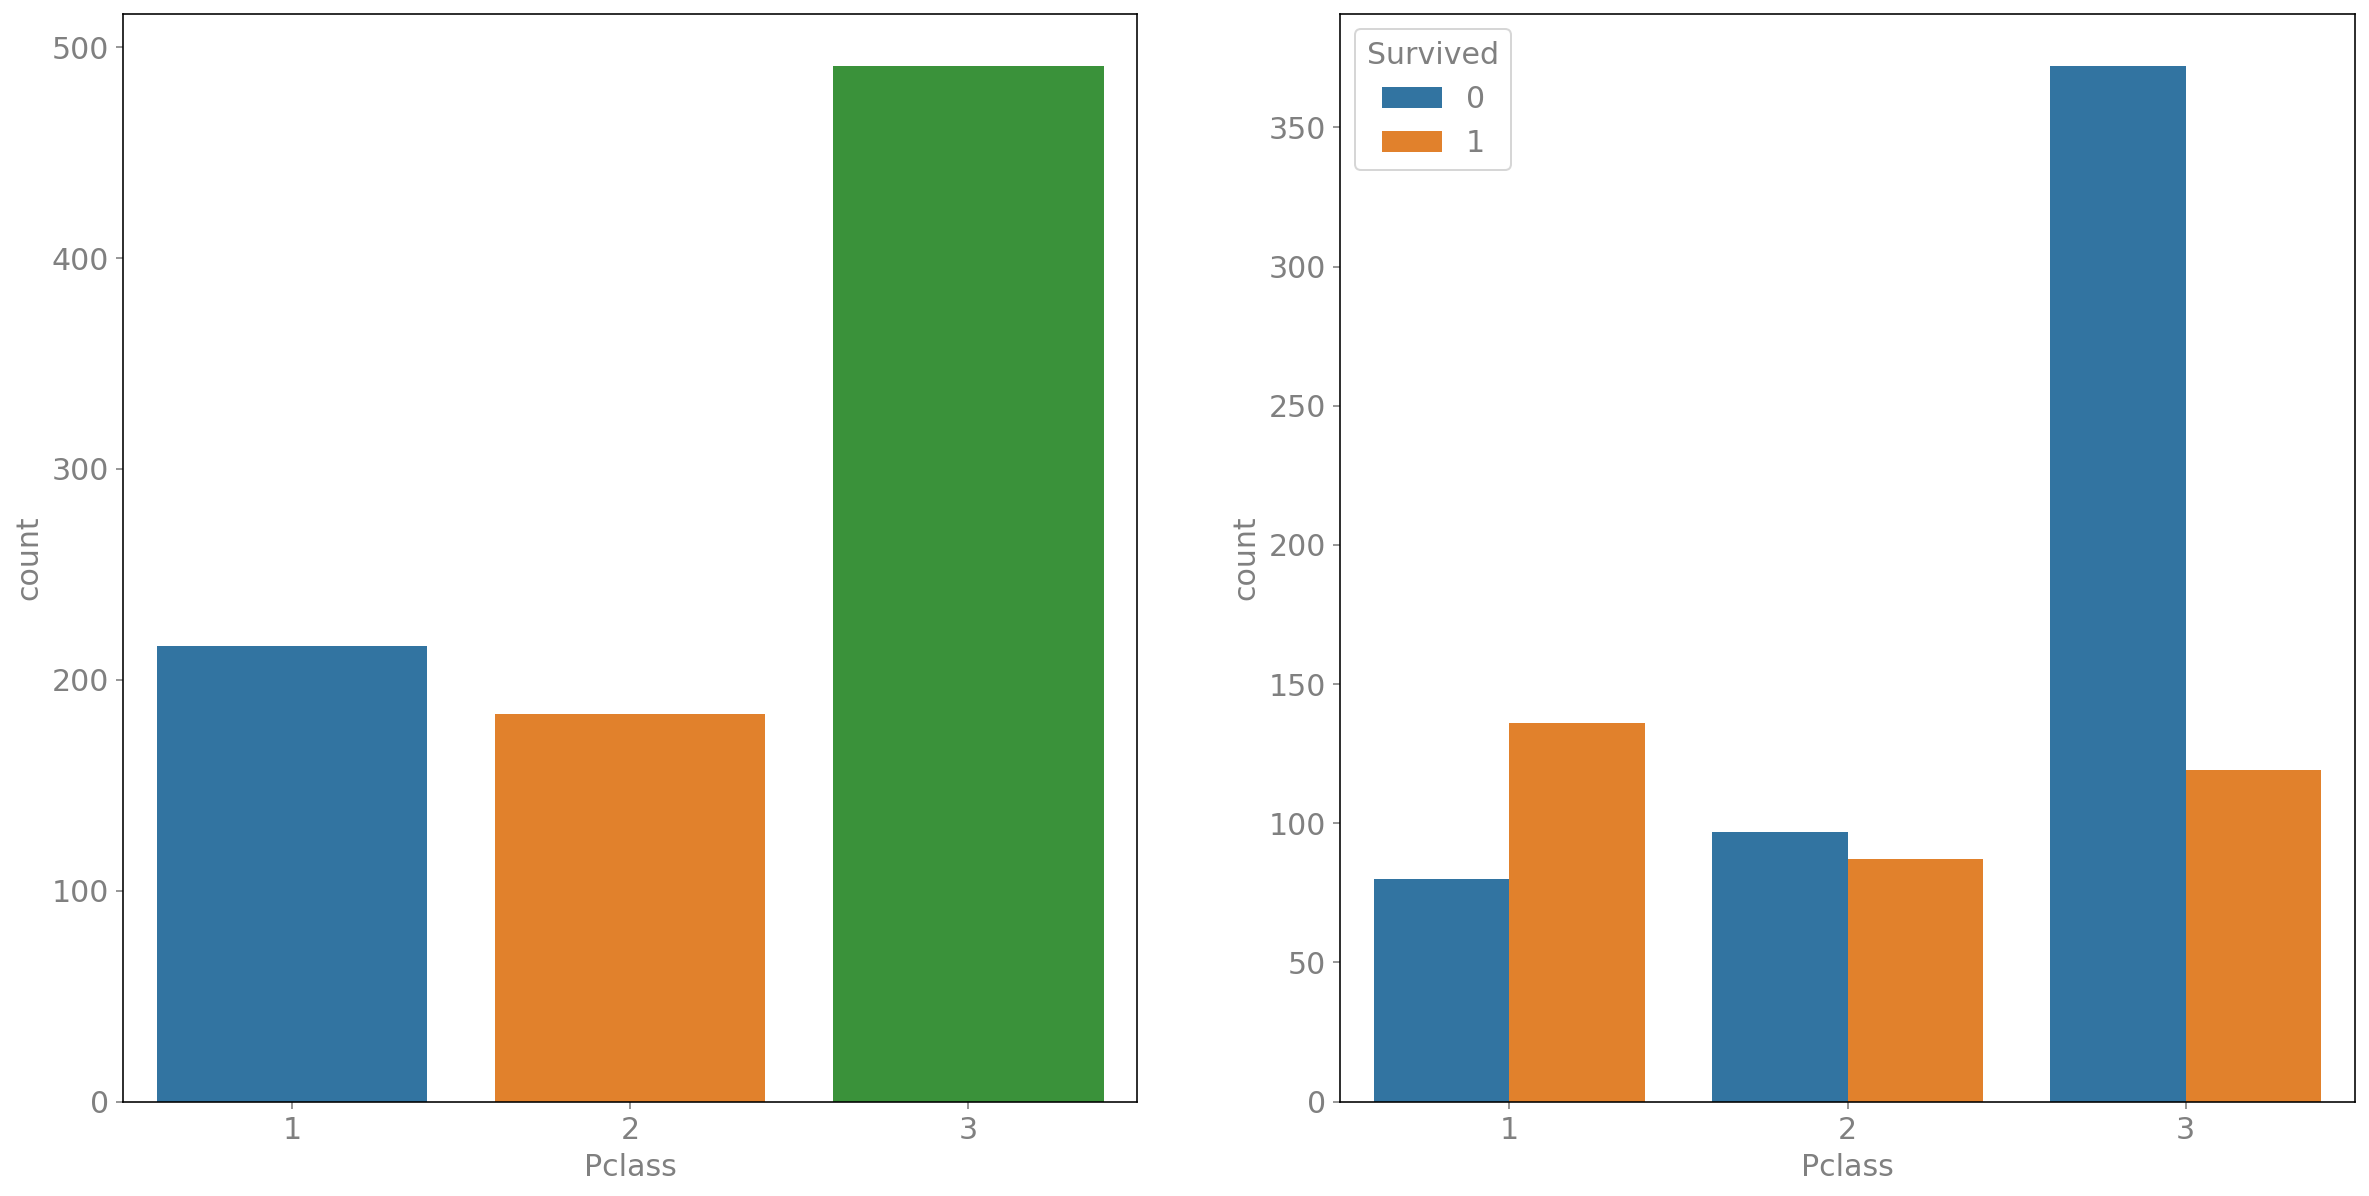

In [18]:
hue_chart(train, 'Pclass')

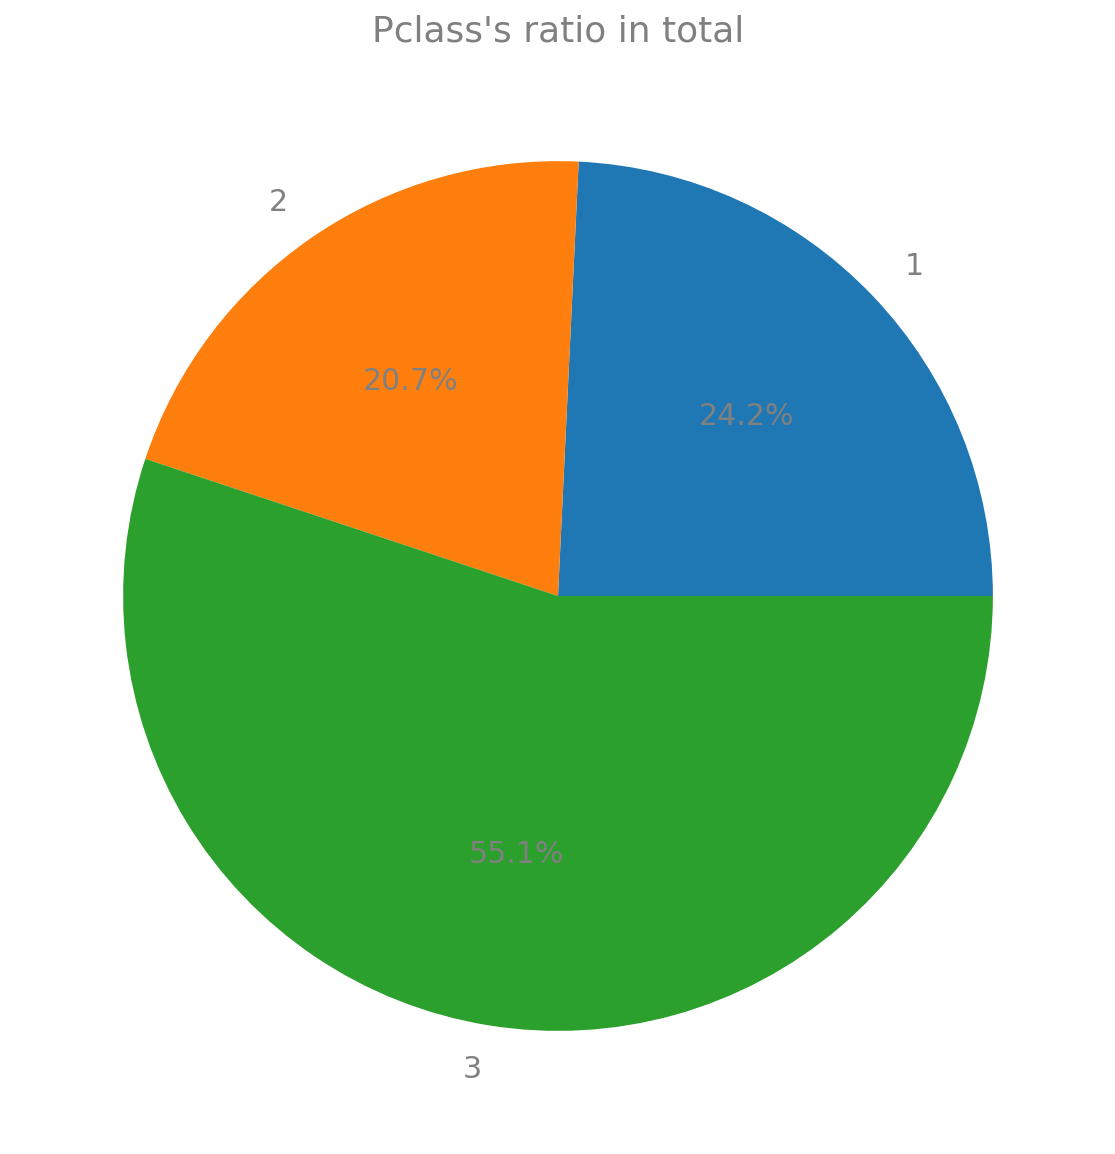

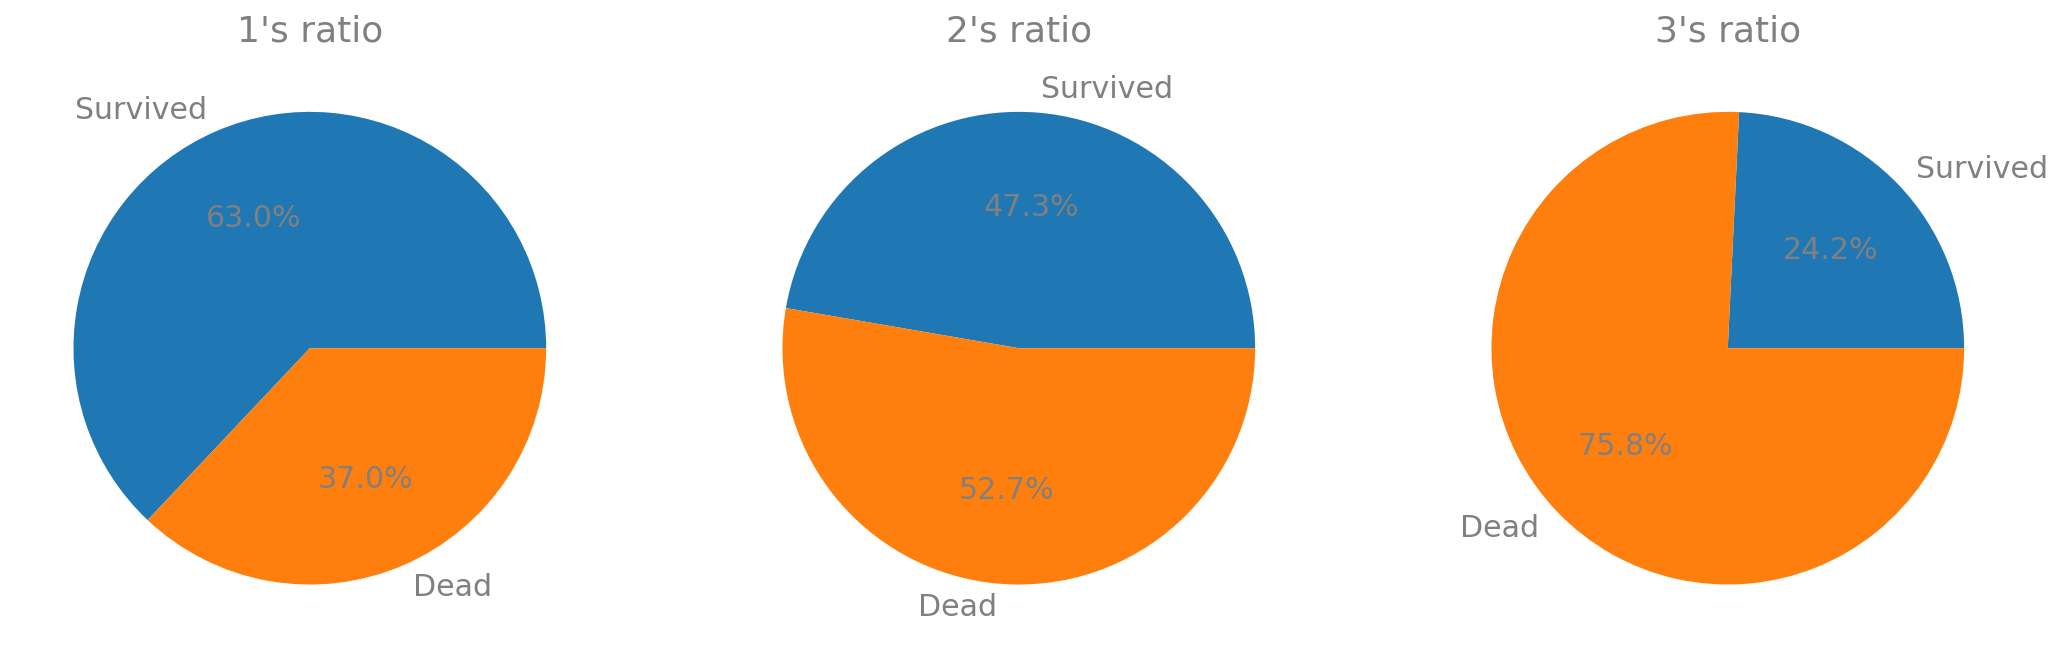

In [19]:
pie_chart(train, 'Pclass')

결론 : 등급이 높을 수록 생존률이 높음을 알 수 있다.

In [20]:
train['Cabin category'] = train['Cabin'].str[:1]

In [21]:
train['Cabin category'].value_counts().sort_index()

A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: Cabin category, dtype: int64

In [22]:
train['Cabin category'].describe()

count     204
unique      8
top         C
freq       59
Name: Cabin category, dtype: object

<AxesSubplot:xlabel='Cabin category', ylabel='count'>

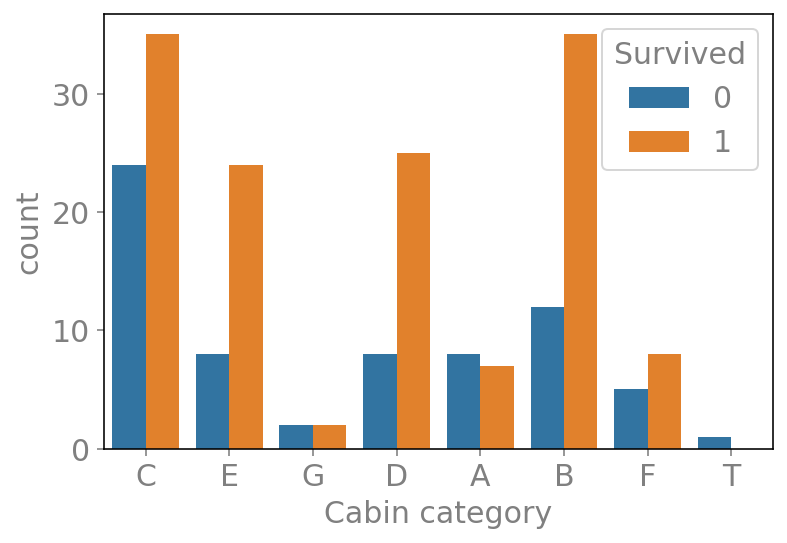

In [23]:
sn.countplot(data=train, x='Cabin category', hue='Survived')

8개의 category 중 5개의 생존률이 50%이상, 2개가 약 50%, 1개가 100%이다(T의 샘플은 1개이다).

In [24]:
train[train['Survived']==1]['Cabin category'].value_counts().sum()

136

In [25]:
train[train['Survived']==0]['Cabin category'].value_counts().sum()

68

Cabin category에 null이 아닌 값이 존재하 데이터들의 생존률은 66%(=136/204)임을 알 수 있습니다.

0    549
1    342
Name: Survived, dtype: int64


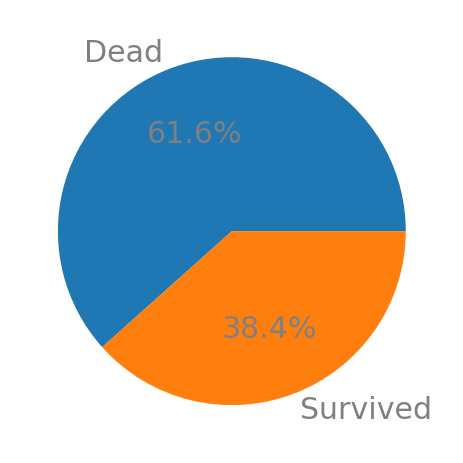

In [26]:
plt.pie(train['Survived'].value_counts(), labels=['Dead', 'Survived'], autopct='%1.1f%%')
print(train['Survived'].value_counts())

전체 생존률에 빗대어 봤을 때 Cabin을 임의로 채우기란 어려워 보인다. 사견으로 Cabin은 Pclass를 including하는 정보일 것 같지만 이를 정제하기에는 나의 도메인 지식이 얕다.<br>결론 : Cabin은 feature로서 사용하기 어려워 보인다.

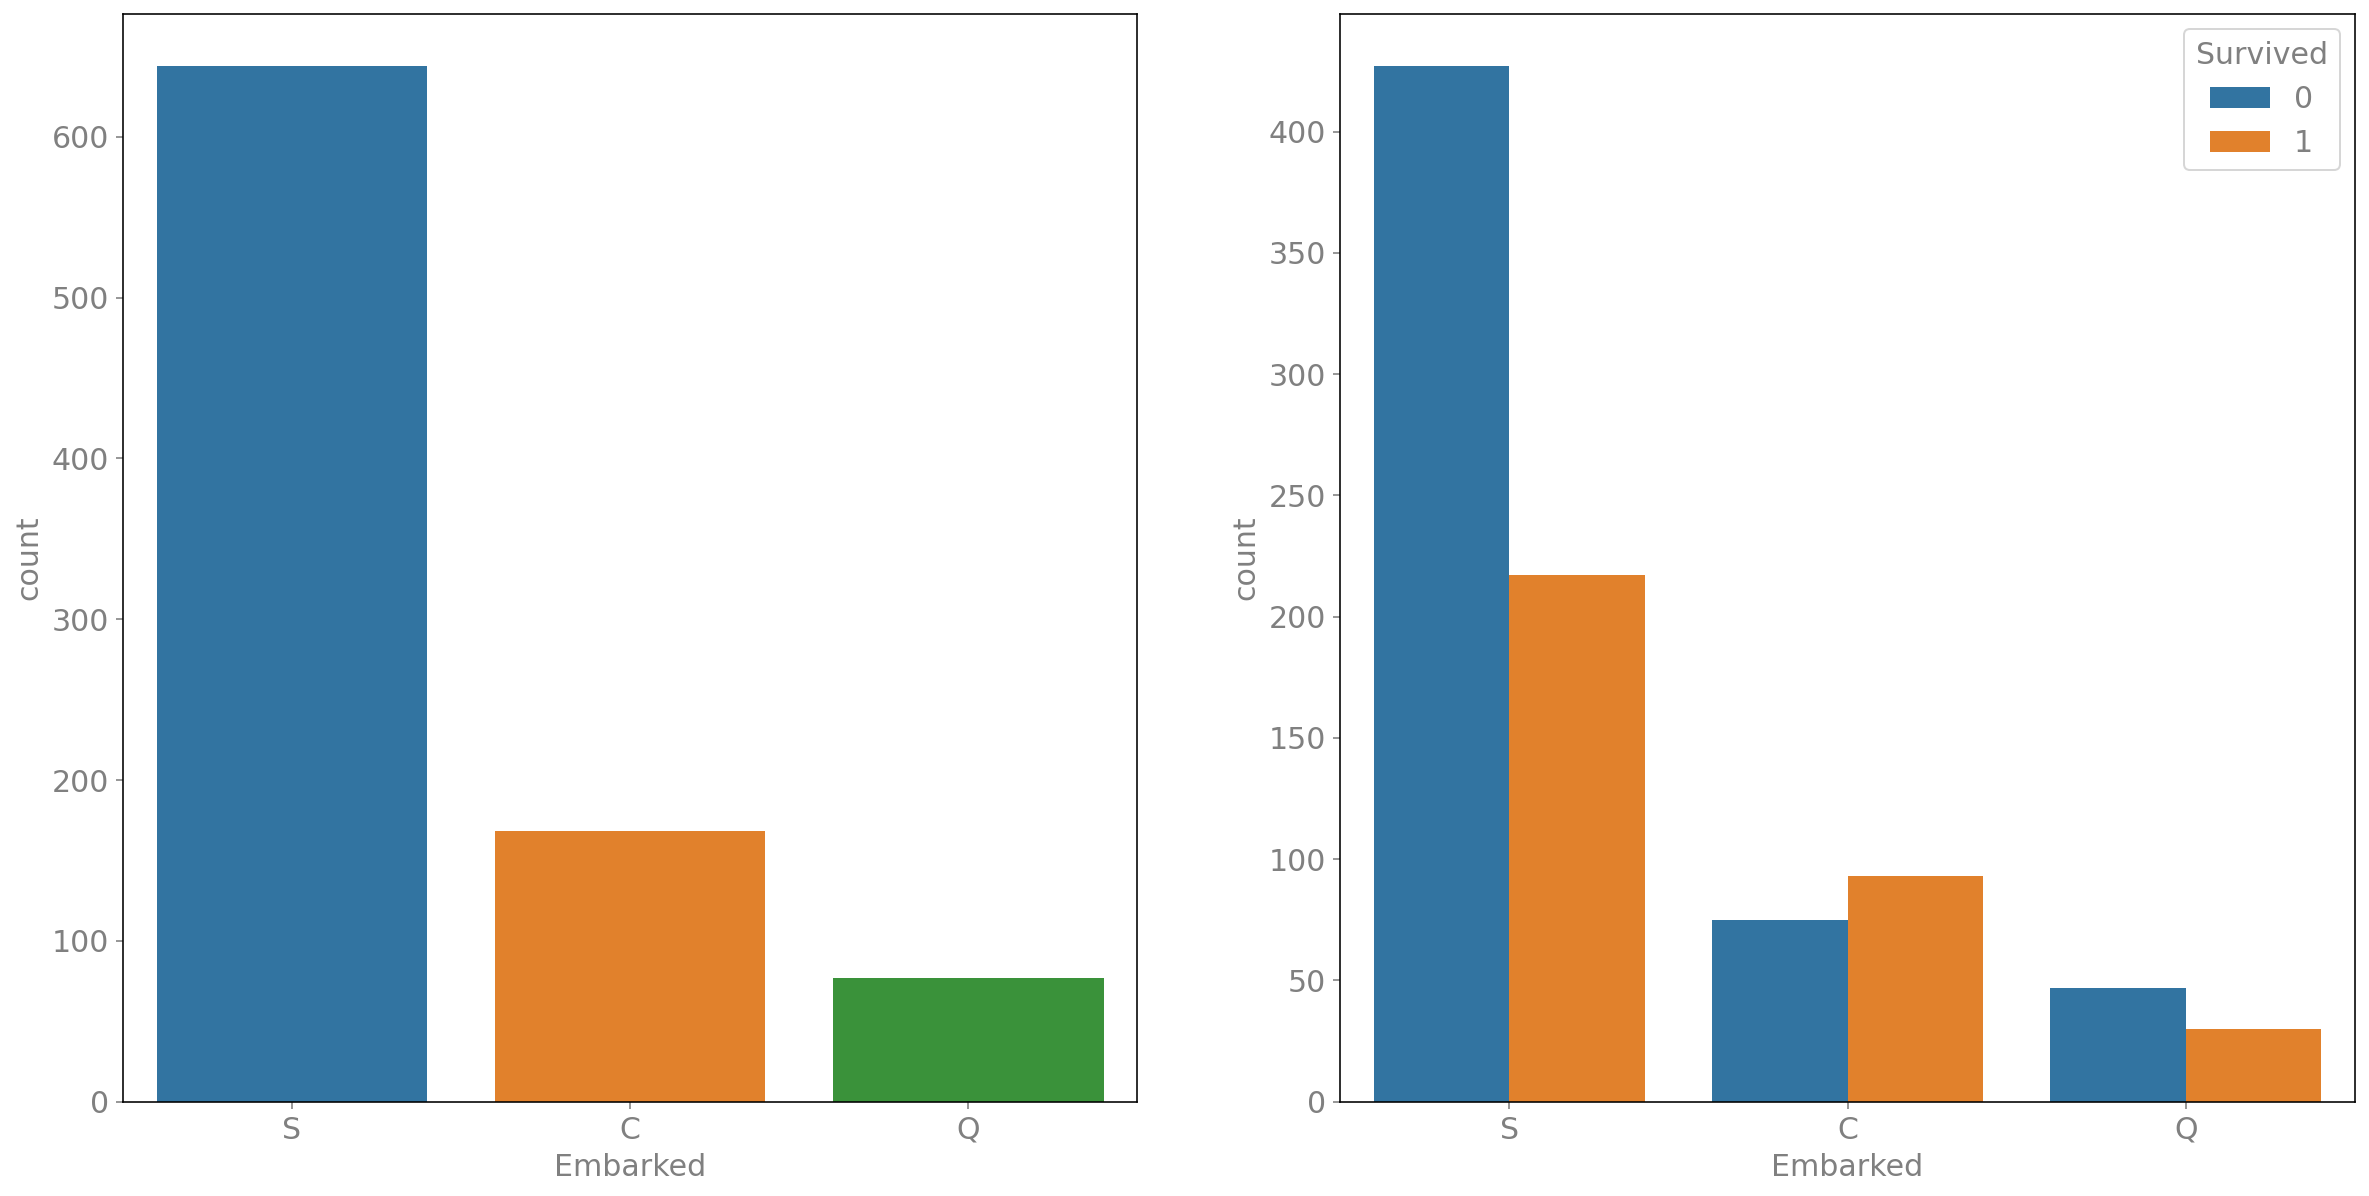

In [27]:
hue_chart(train, 'Embarked')

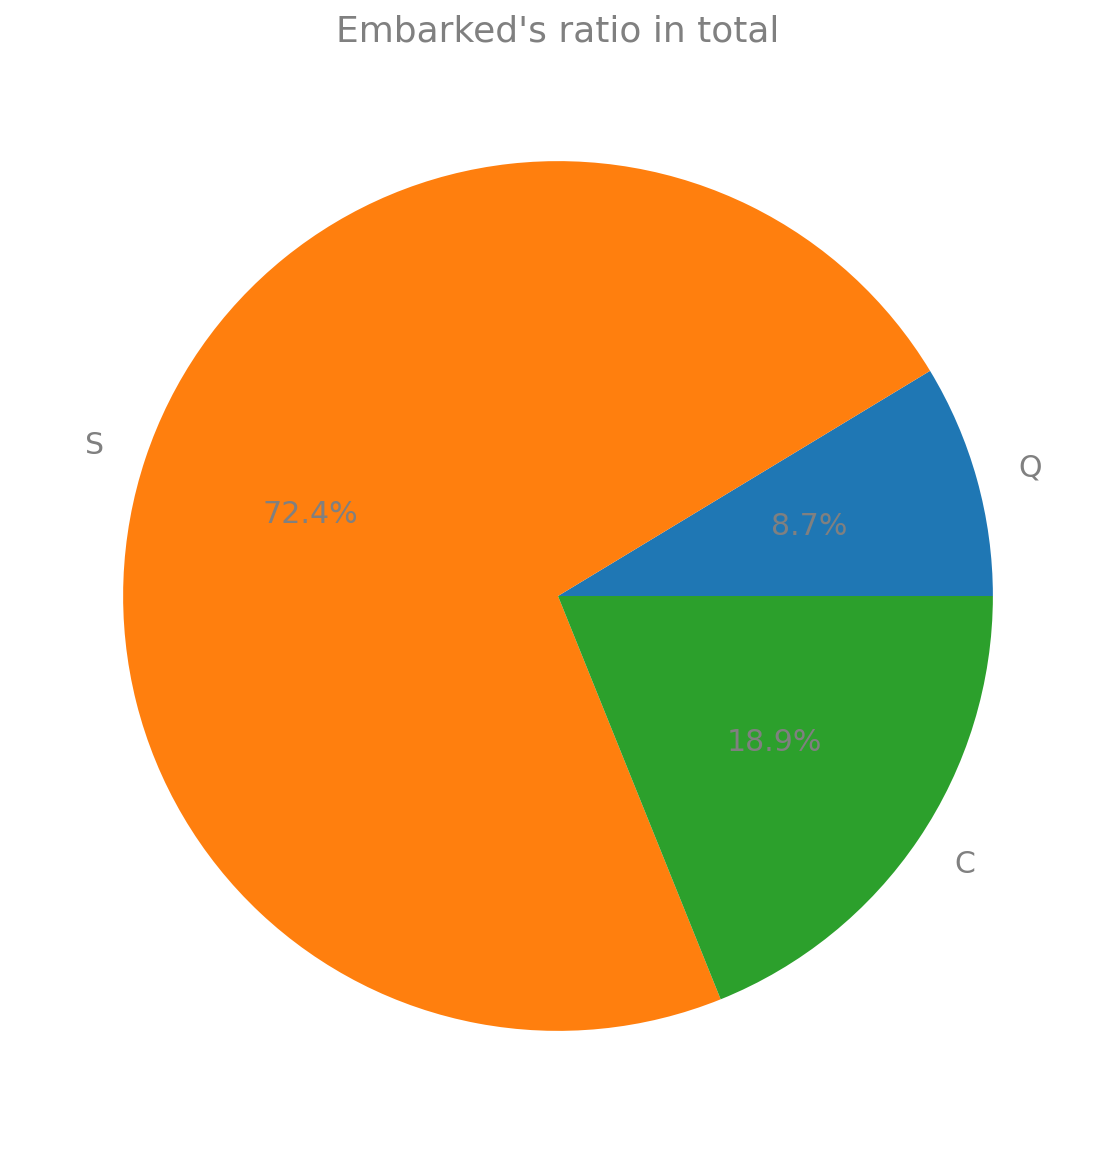

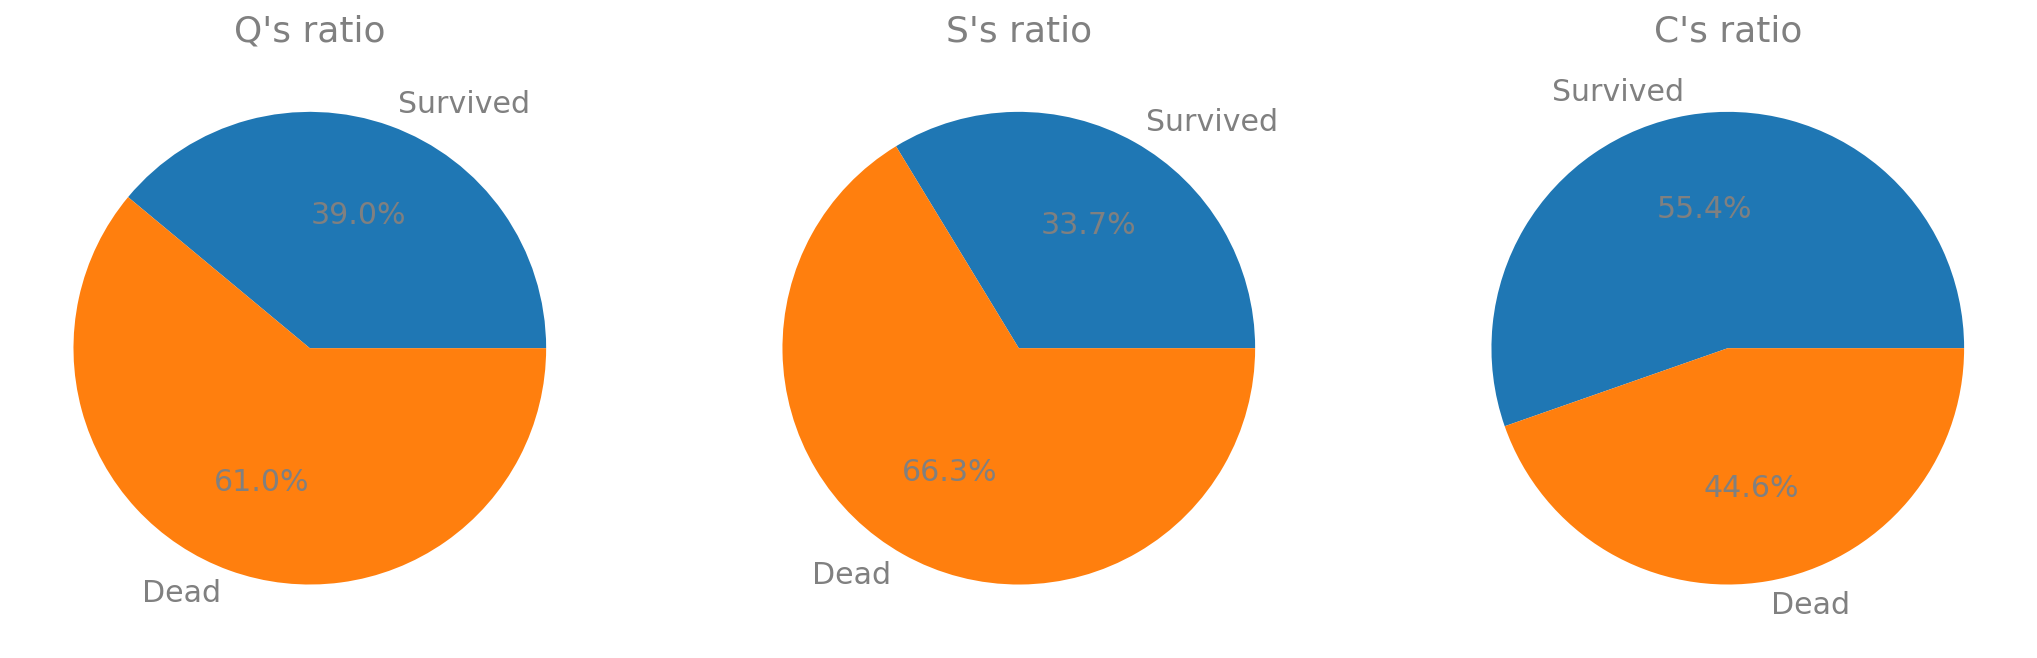

In [28]:
pie_chart(train, 'Embarked')

Southampton에 선착한 사람이 가장 많다. <br>결론 : Cherbourg에서 선착한 사람들이 나머지 두 선착장에서 선착한 사람들보다 생존률이 높다. 결측치는 S로 채운다.

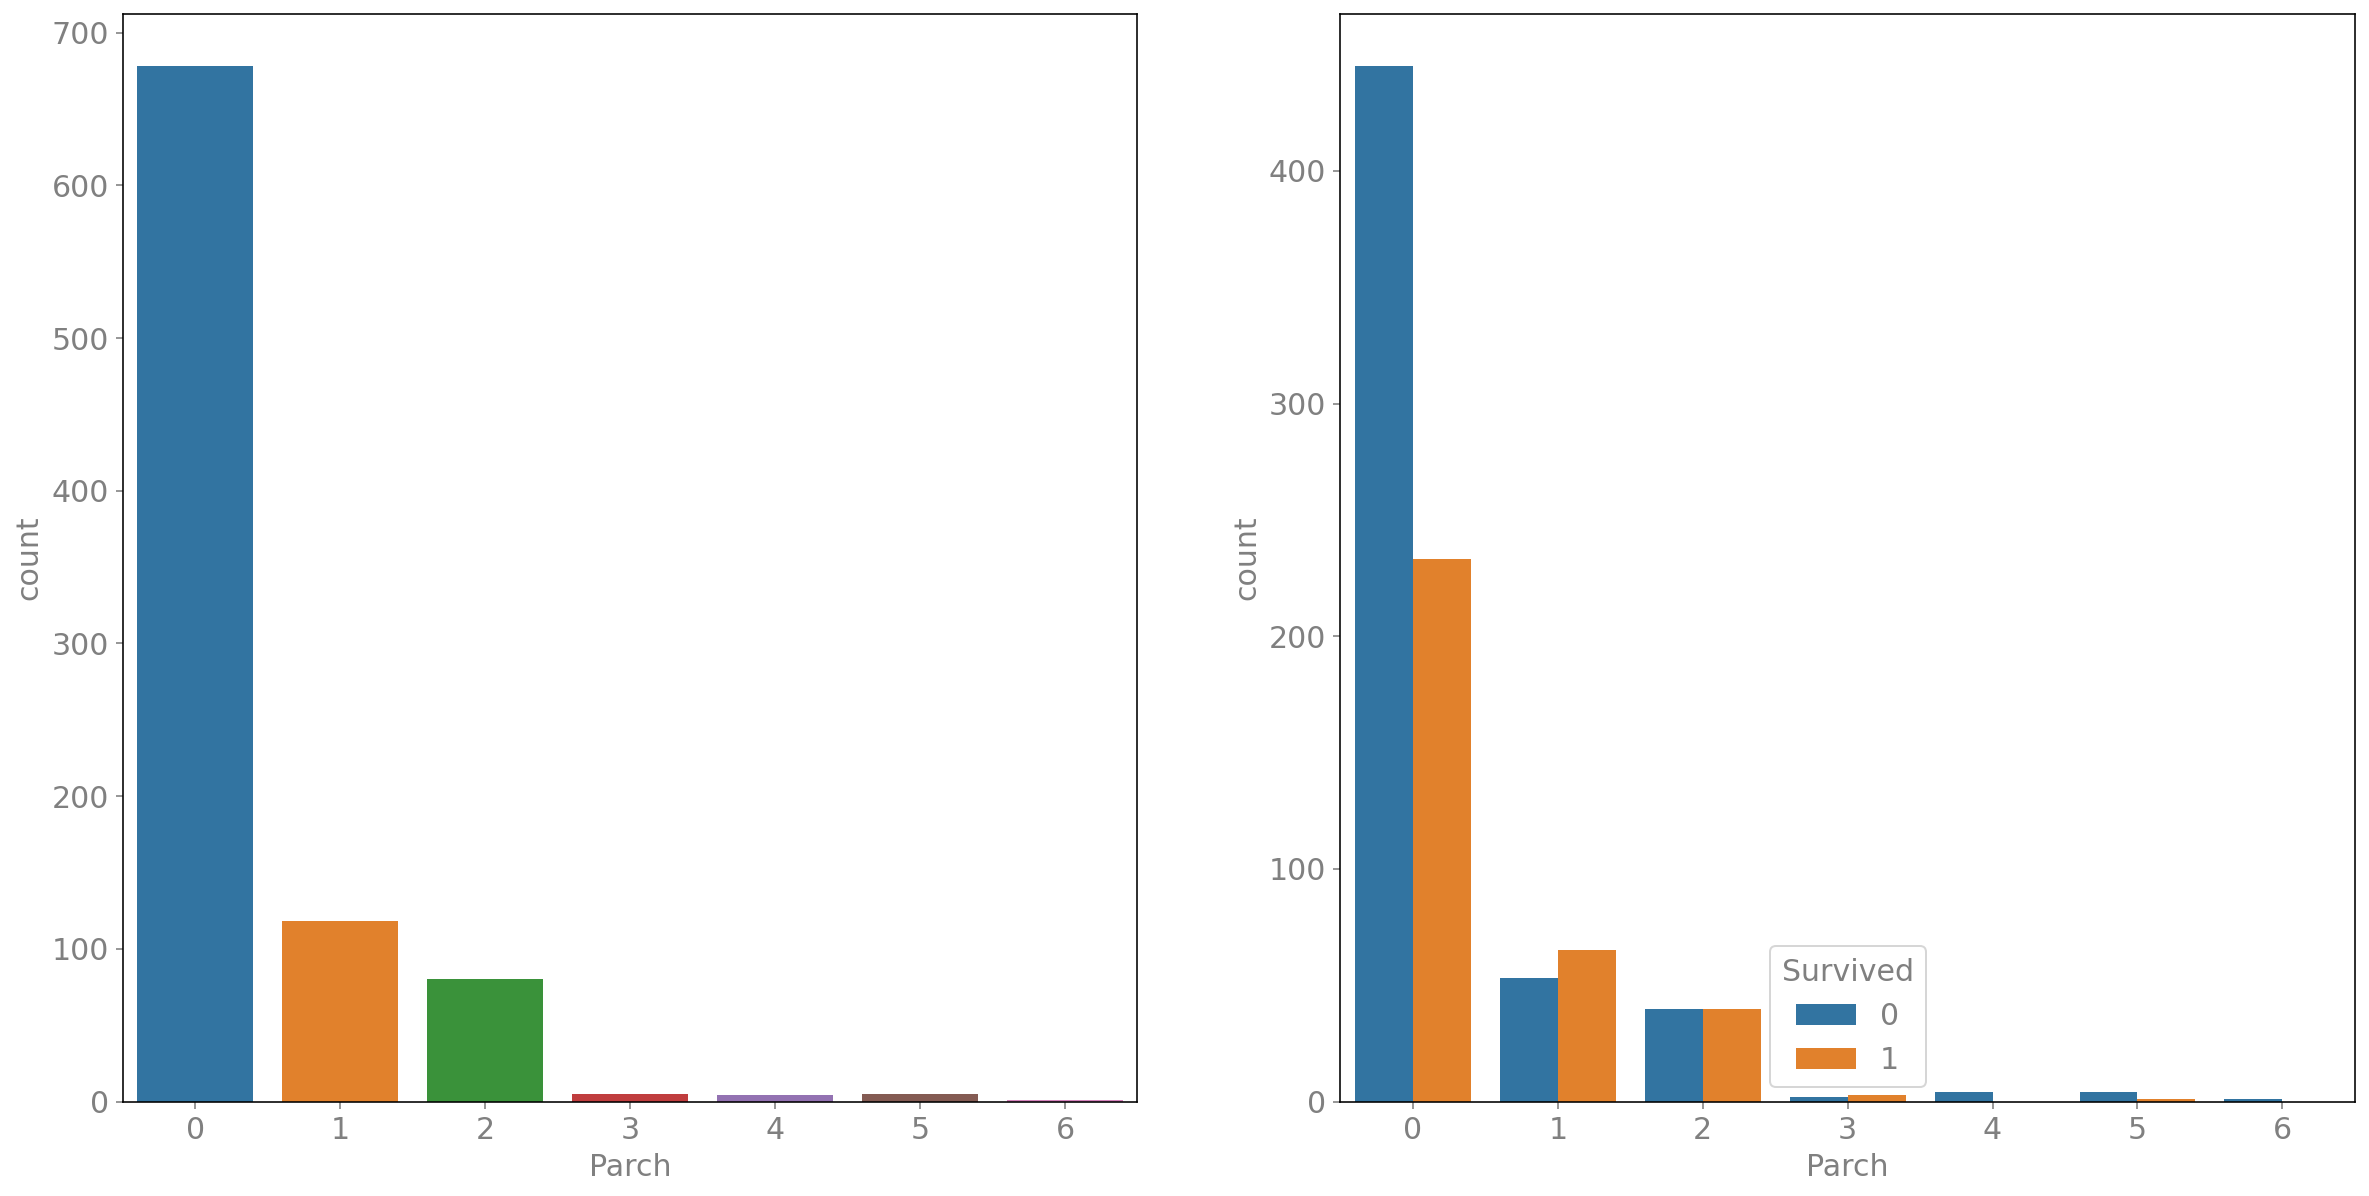

In [29]:
hue_chart(train, 'Parch')

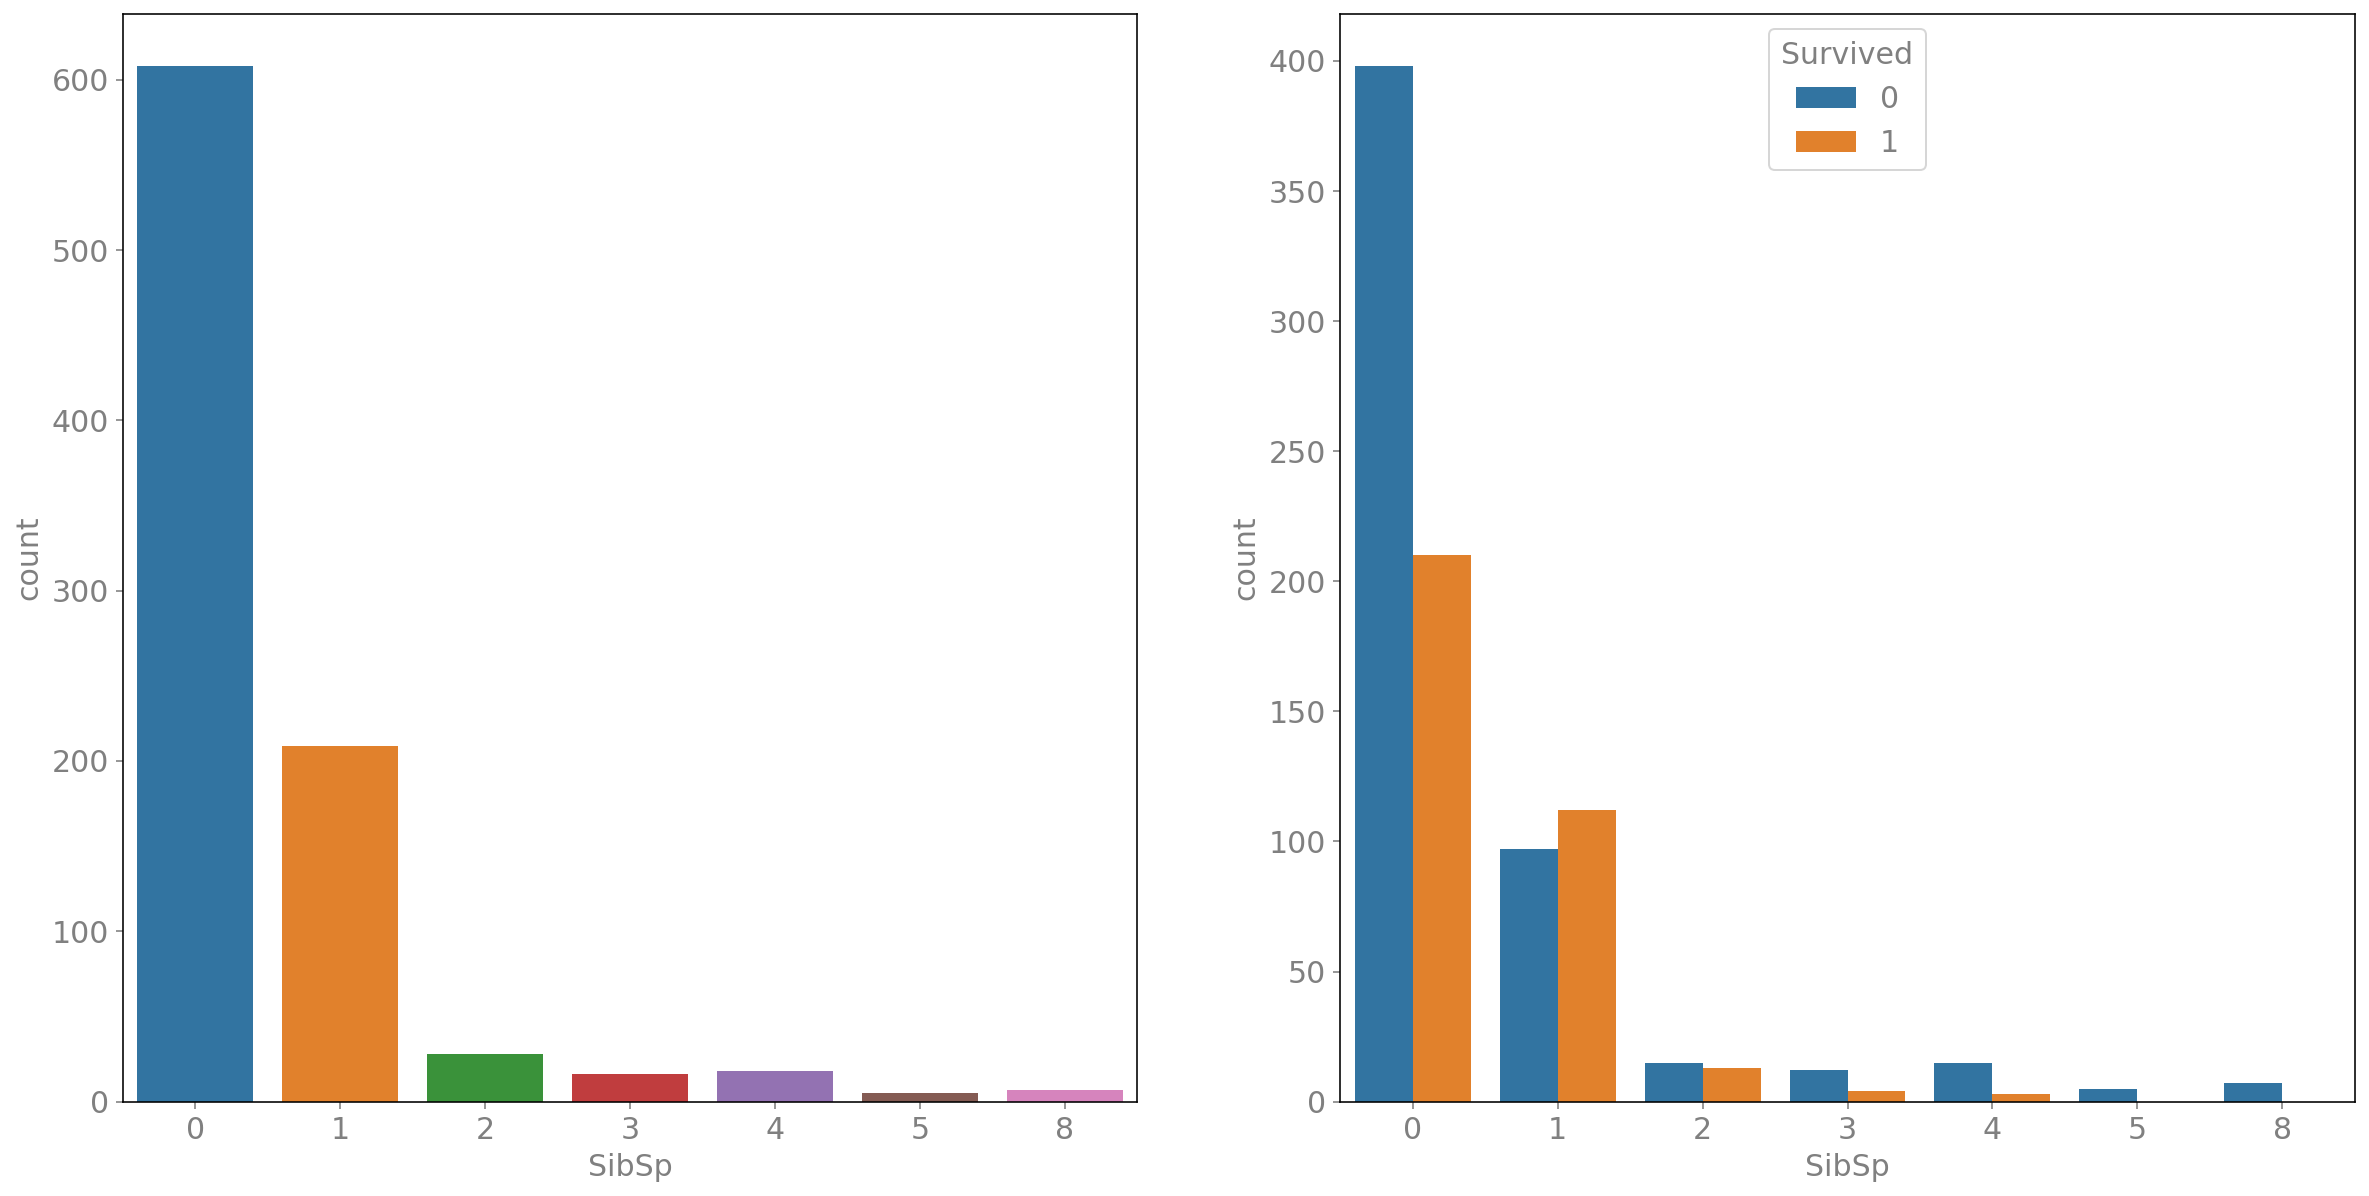

In [30]:
hue_chart(train, 'SibSp')

Parch와 SibSp은 각 카테고리별로 비슷한 생존률을 가진다. <br>또한 두 feature 모두 가족구성원을 뜻하므로 두 feature을 Family라는 하나의 feature로 묶겠다.

### feature가 많을 수록 그만큼 복잡한 학습 모델이 필요해지는 것이며 이는 과대적합 문제로 빠질 가능성을 높인다. 바꿔 말하면, 모델의 복잡도를 (과소적합까지가 아닌 적절한 지점까지) 낮추면 모델의 정확도도 오를 것이다.

In [31]:
train['Family'] = train['Parch'] + train['SibSp'] + 1

In [32]:
train['Family'].describe()

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Family, dtype: float64

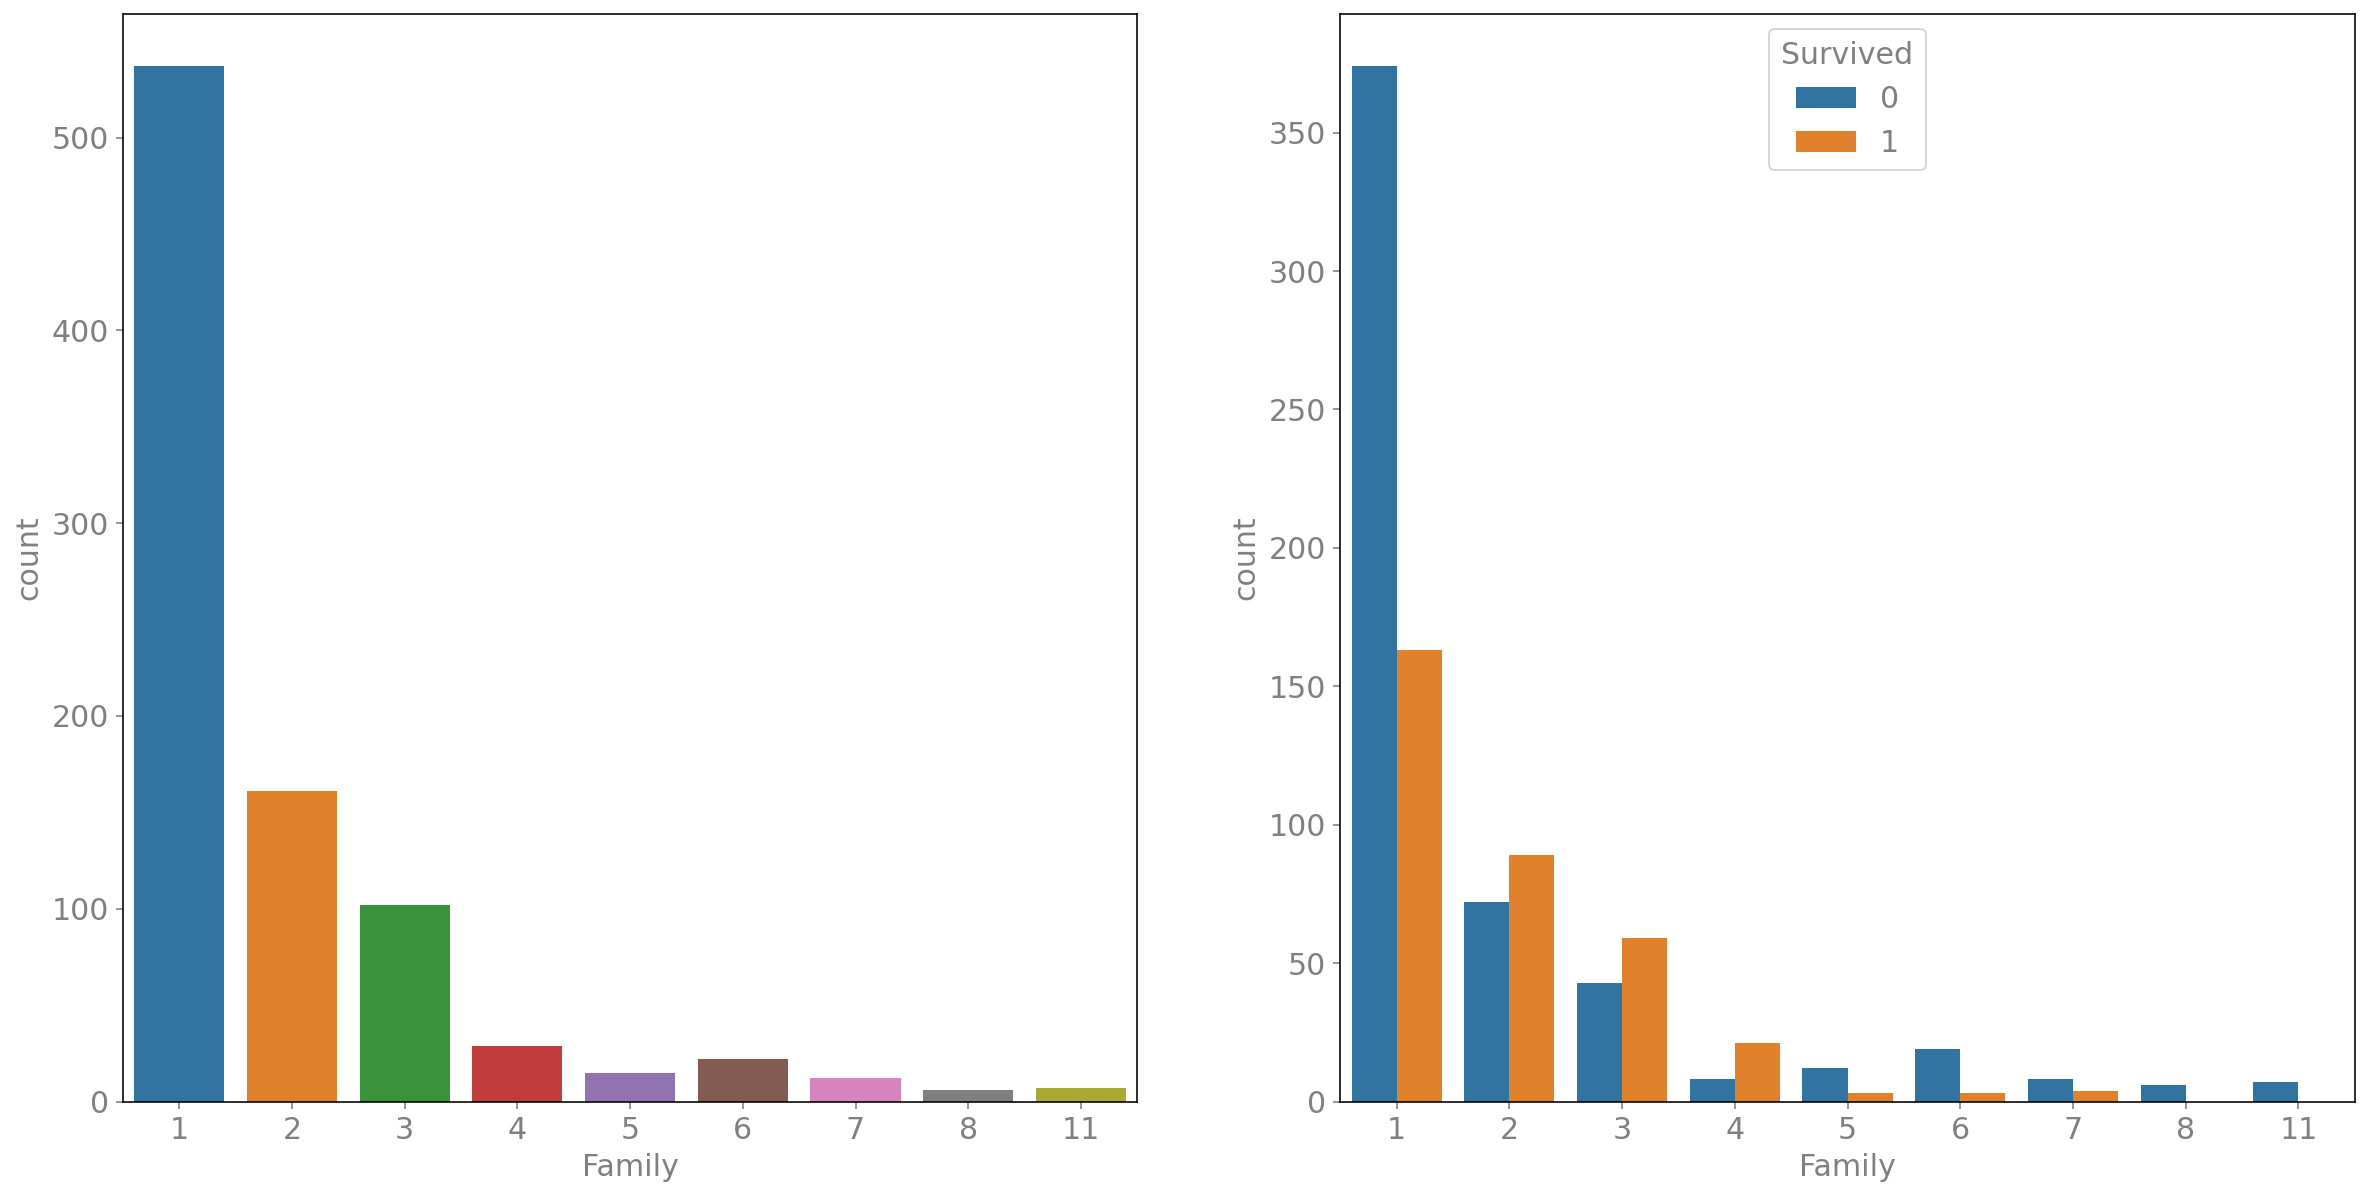

In [33]:
hue_chart(train, 'Family')

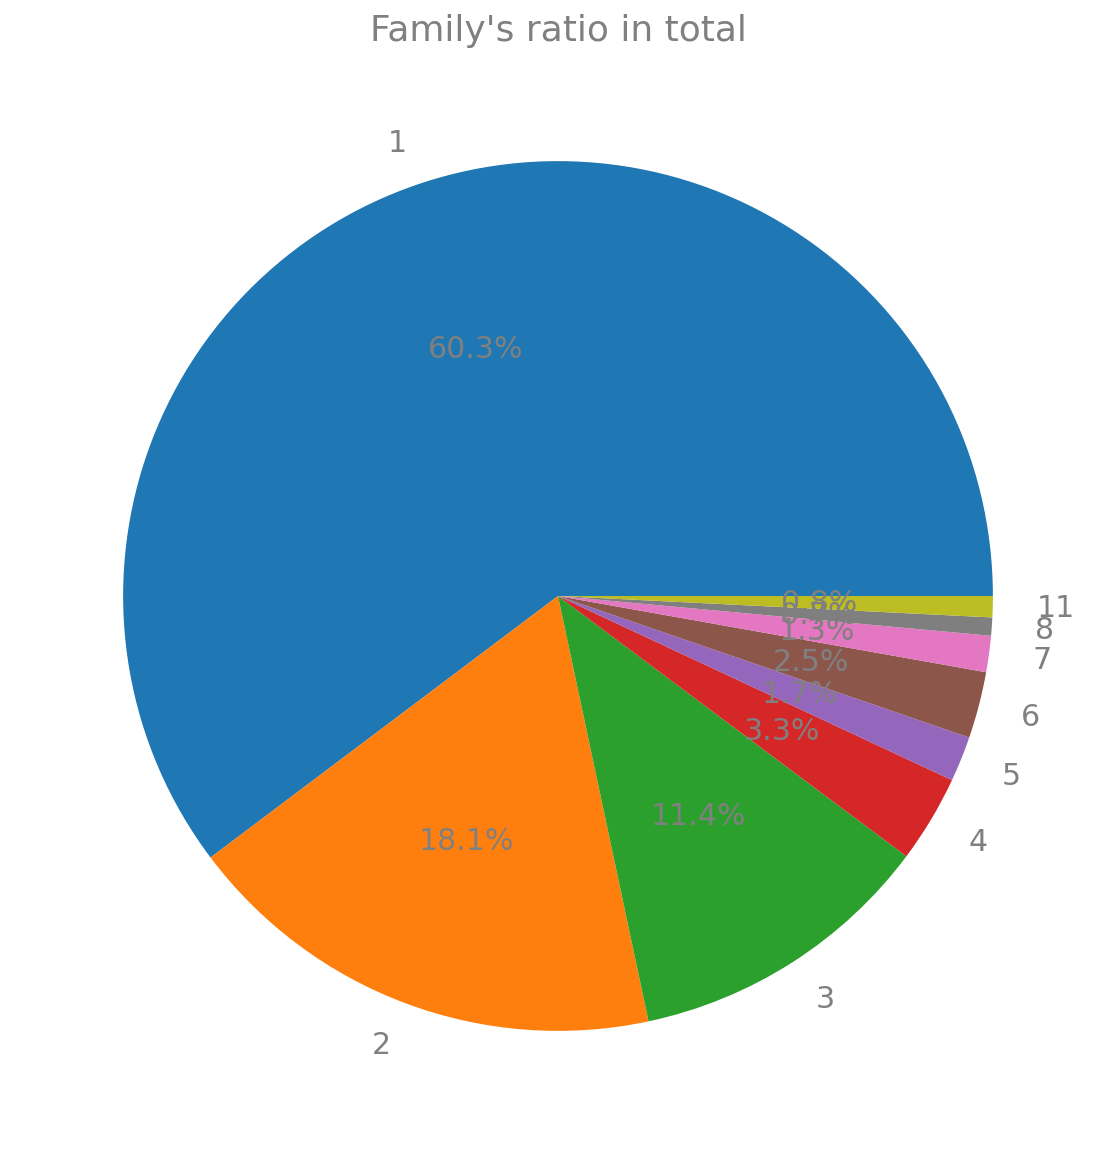

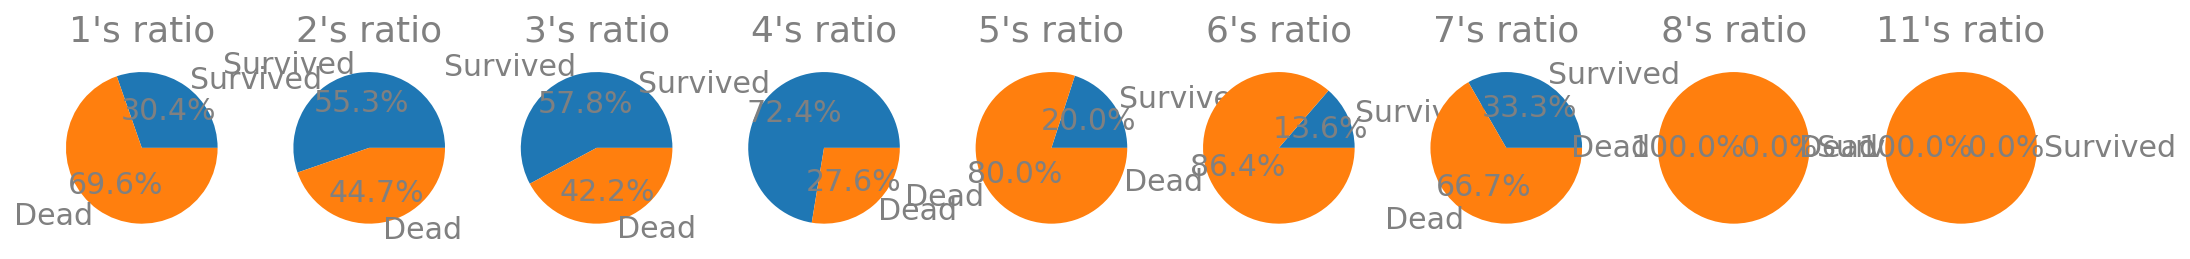

In [34]:
pie_chart(train, 'Family')

혼자 탑승한 경우 생존률이 약 30%이며 2명에서 4명의 가족은 생존률이 50%이상이다. 5명에서 7명의 가족은 30% 이하의 생존률을, 그 이상은 생존률이 0%이다. <br> 
결론 : 4개의 범주로 재설정하는 것이 좋을 것 같다.

In [35]:
train['Family_tmp'] = pd.cut(x=train['Family'], bins=[0, 2, 5, 8, 12], labels=[0, 1, 2, 3])

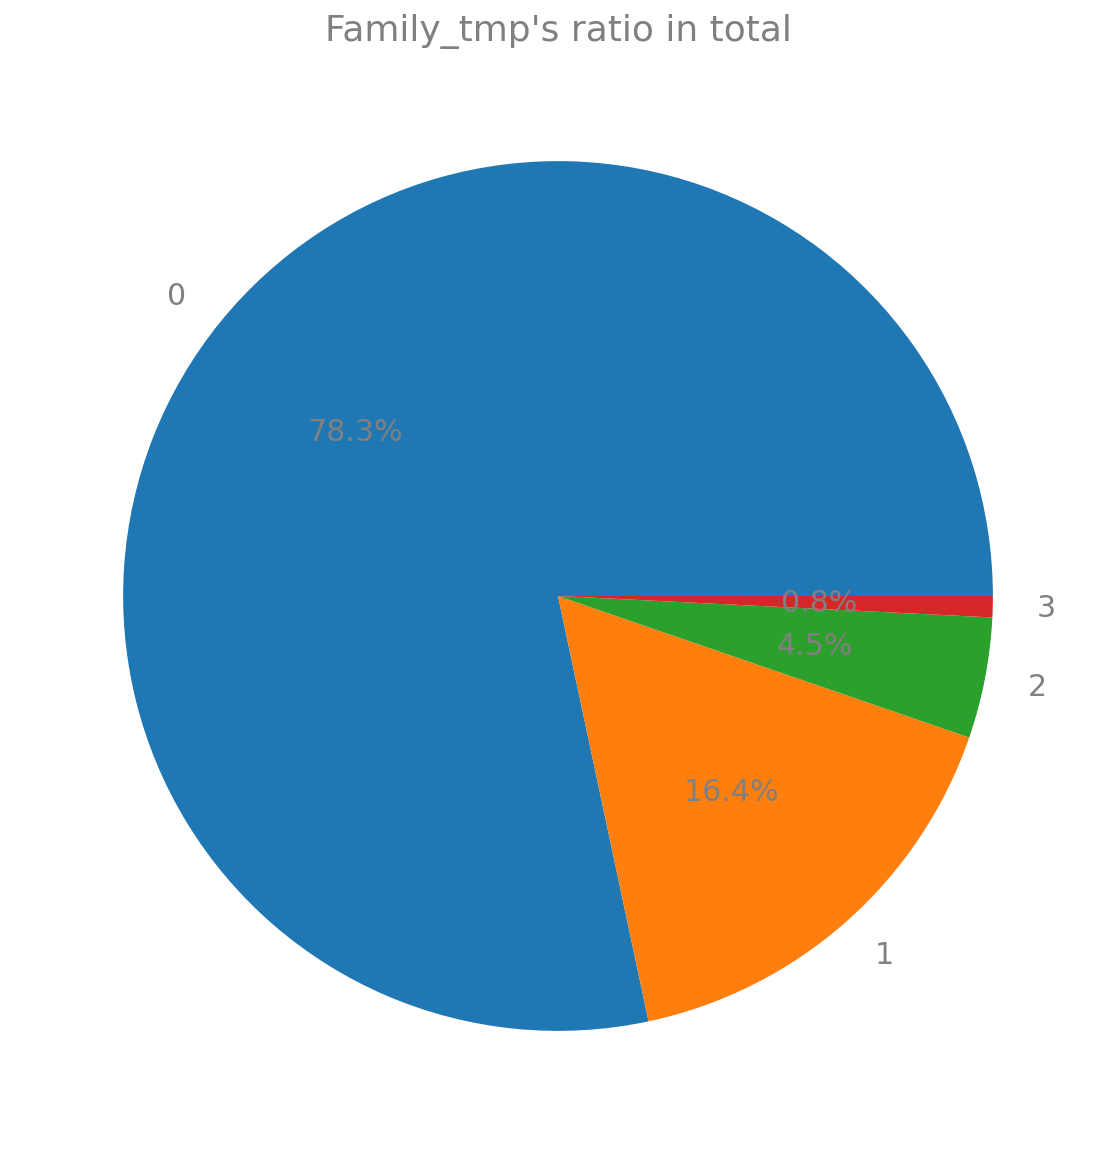

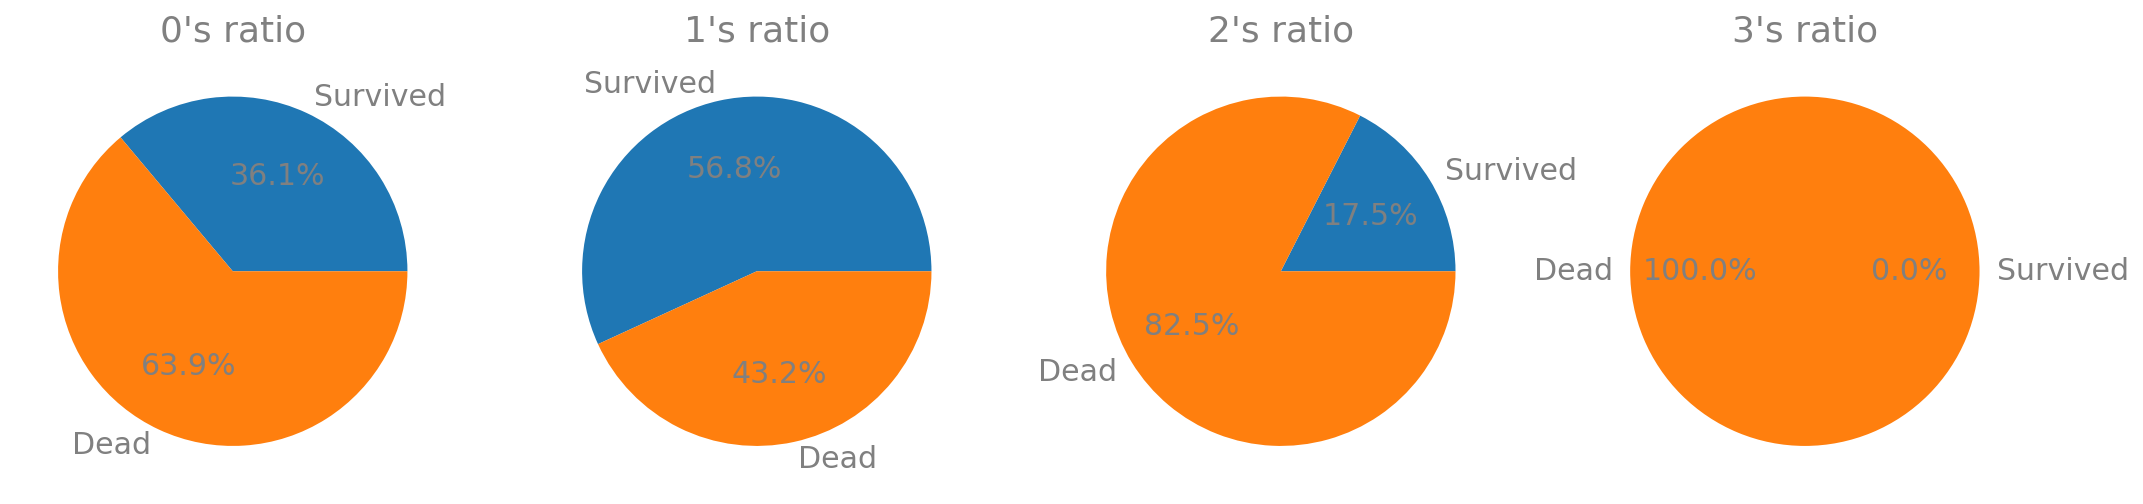

In [36]:
pie_chart(train, 'Family_tmp')

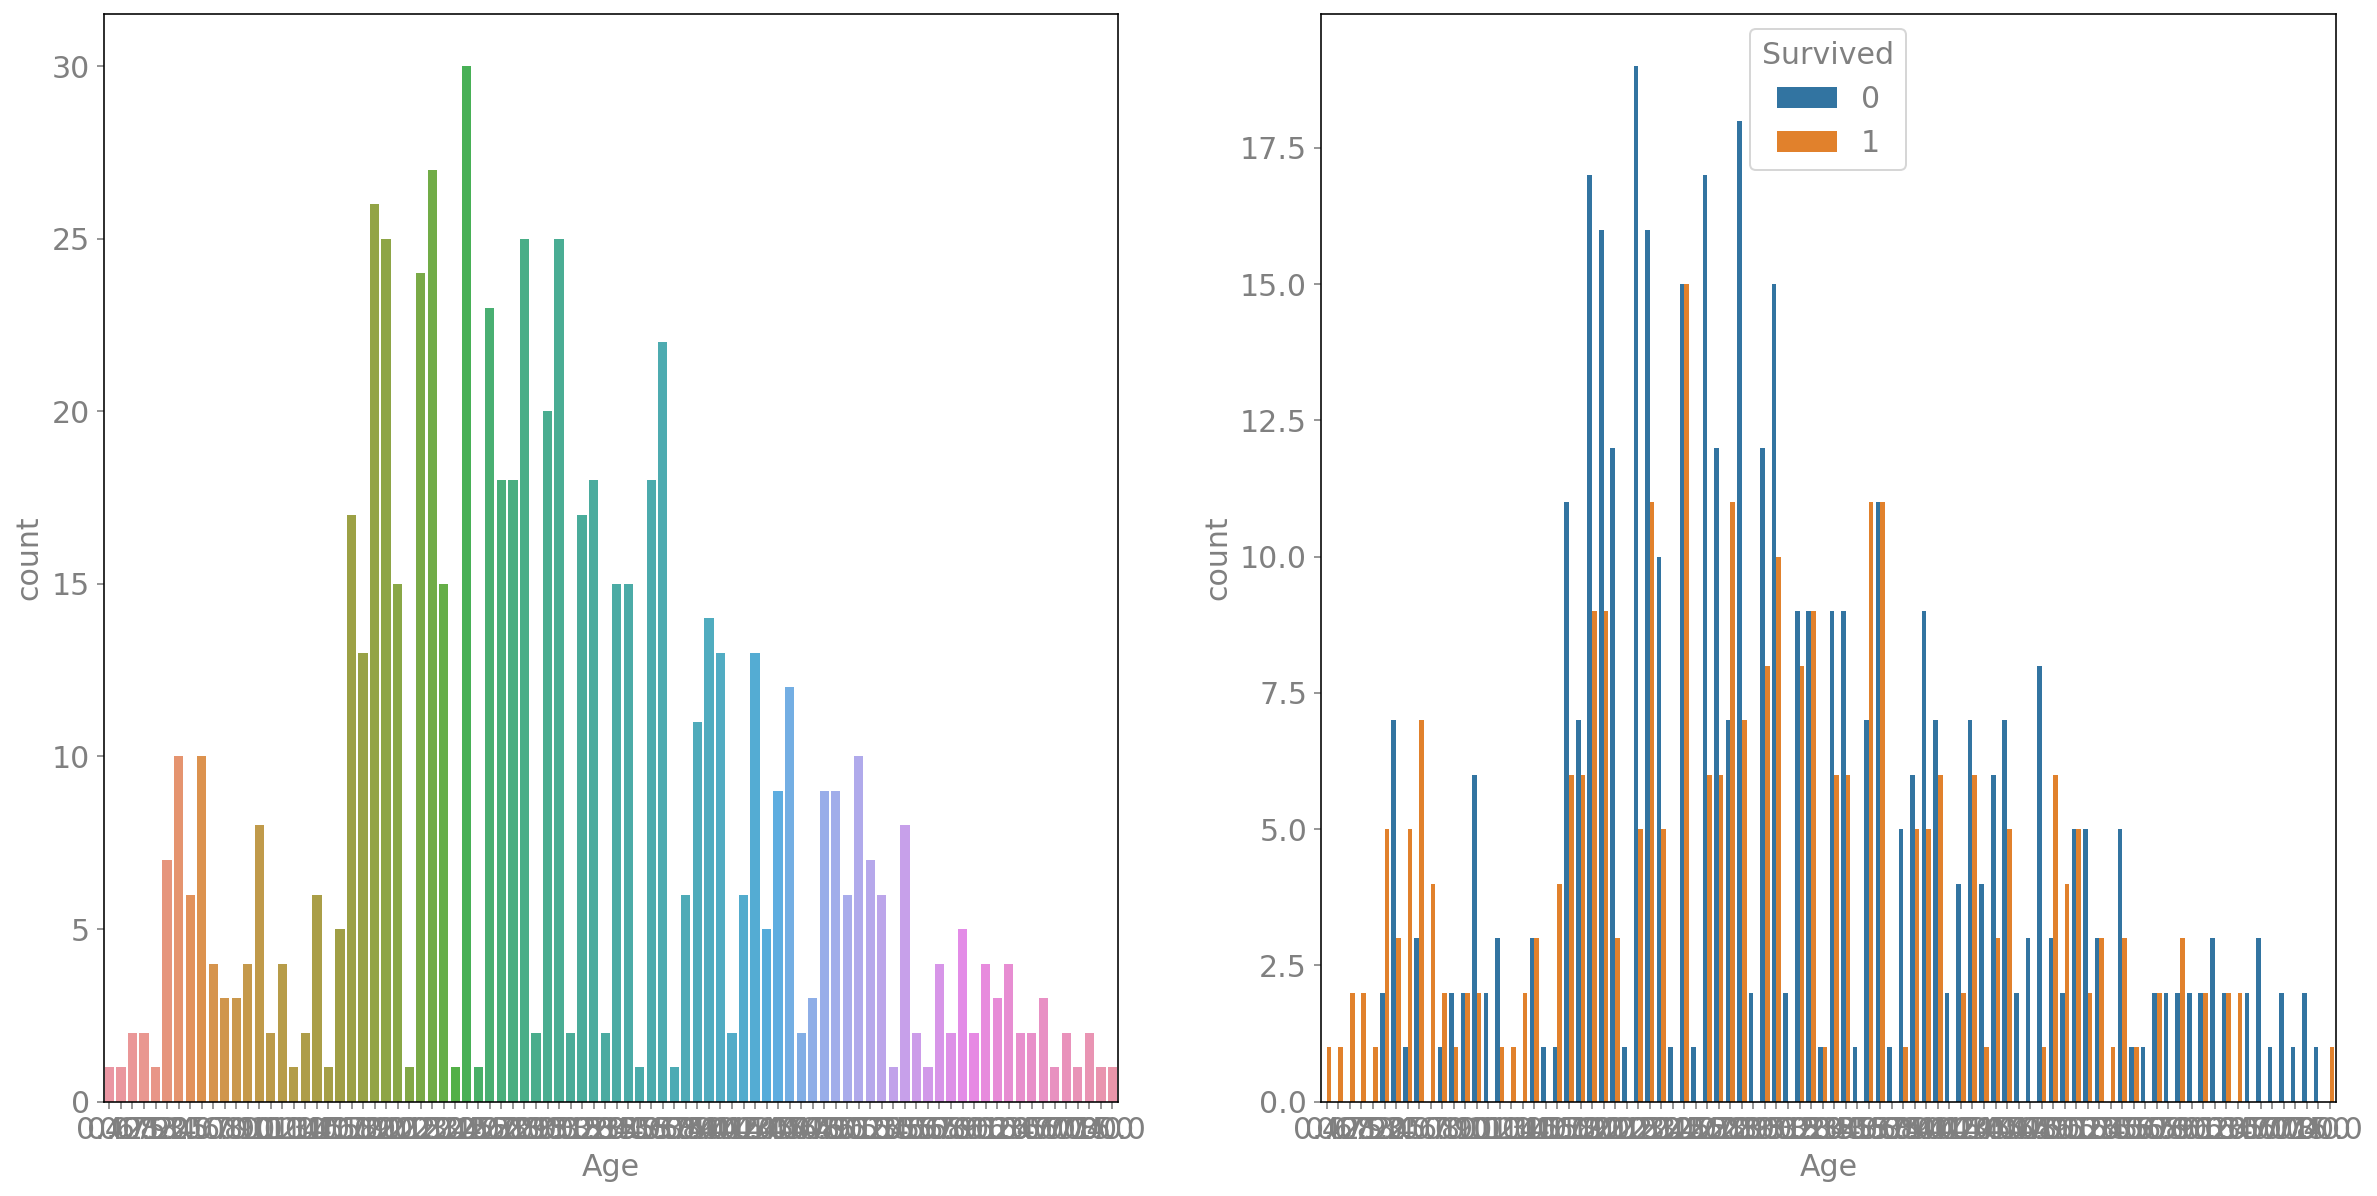

In [37]:
hue_chart(train, 'Age')

Age와 Fare는 연속형 자료이다 보니 기존의 표로 분석하기 쉽지 않아 보인다.

<AxesSubplot:xlabel='Age'>

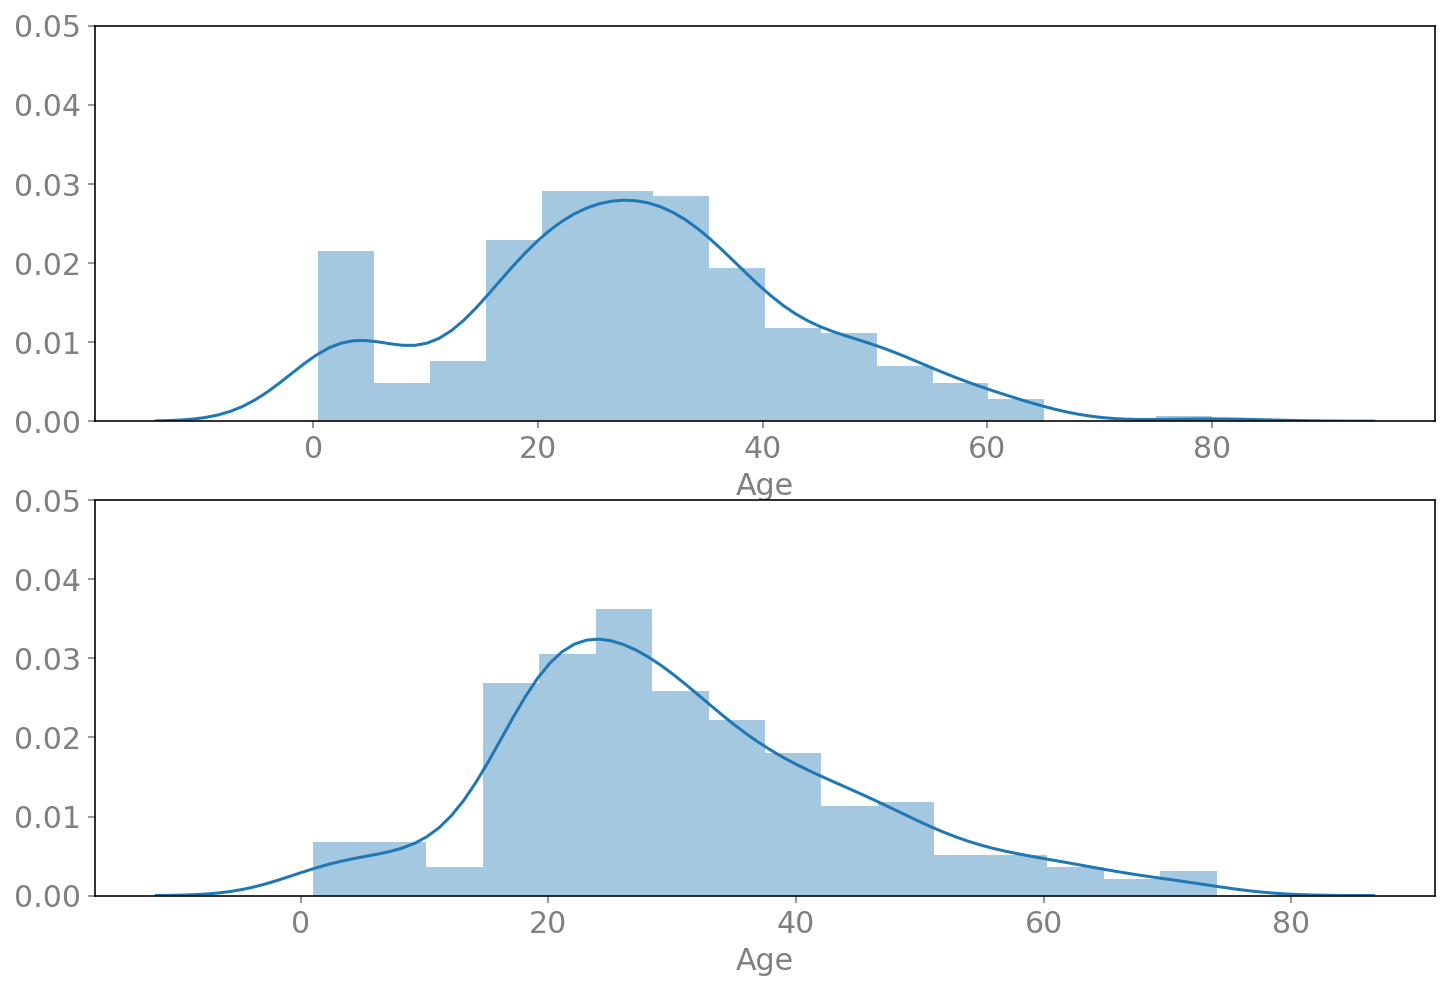

In [38]:
figure, axes = plt.subplots(nrows=2, ncols=1)

figure.set_size_inches(12, 8)

axes[0].set_ylim(0, 0.05)
sn.distplot(train[train['Survived'] == 1]['Age'], ax = axes[0])
axes[1].set_ylim(0, 0.05)
sn.distplot(train[train['Survived'] == 0]['Age'], ax = axes[1])

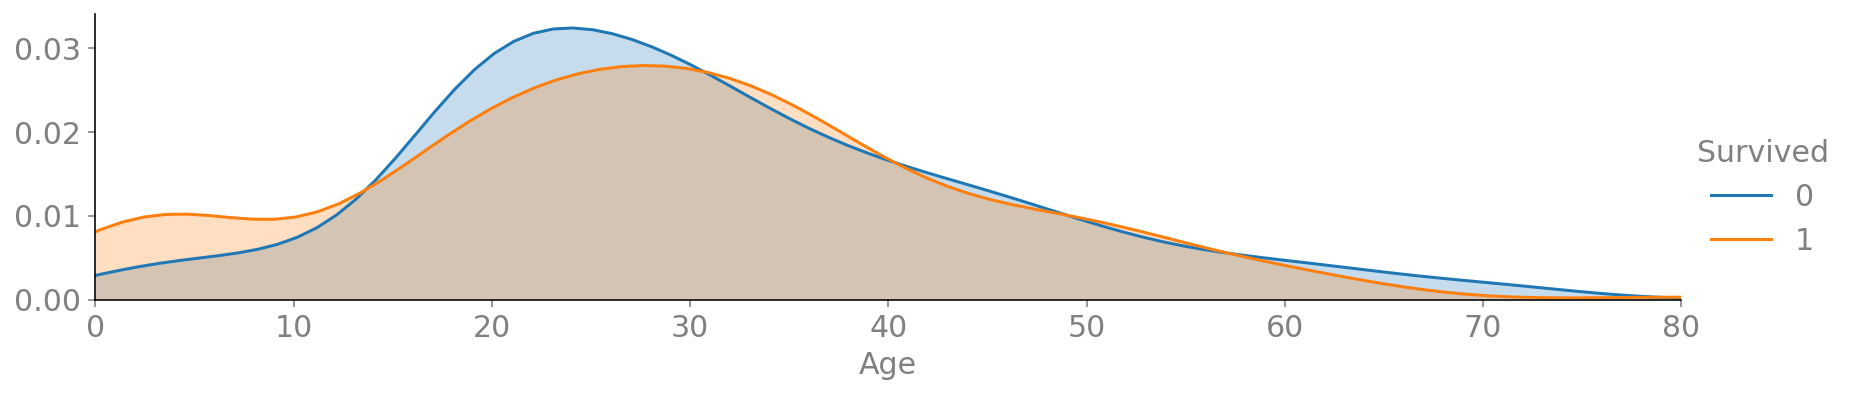

In [39]:
facet = sn.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
facet.set(xlim=(0, train['Age'].max()))

10살 전까지의 생존률은 50% 이상이고, 10살부터 30살까지의 생존률은 50%가 안된다. 30살 이후부터는 거의 50%이다. <br>
이는 714개의 데이터(Age의 결측치는 전체 데이터 891개 중에 177개이다)를 통해 도출한 결론이다.

Age의 결측치를 채우기 전에, Age와 연관된 다른 feature가 무엇이 있을까 생각하다가 Family, Sex, Pclass가 떠올랐다.

[(0.0, 80.0)]

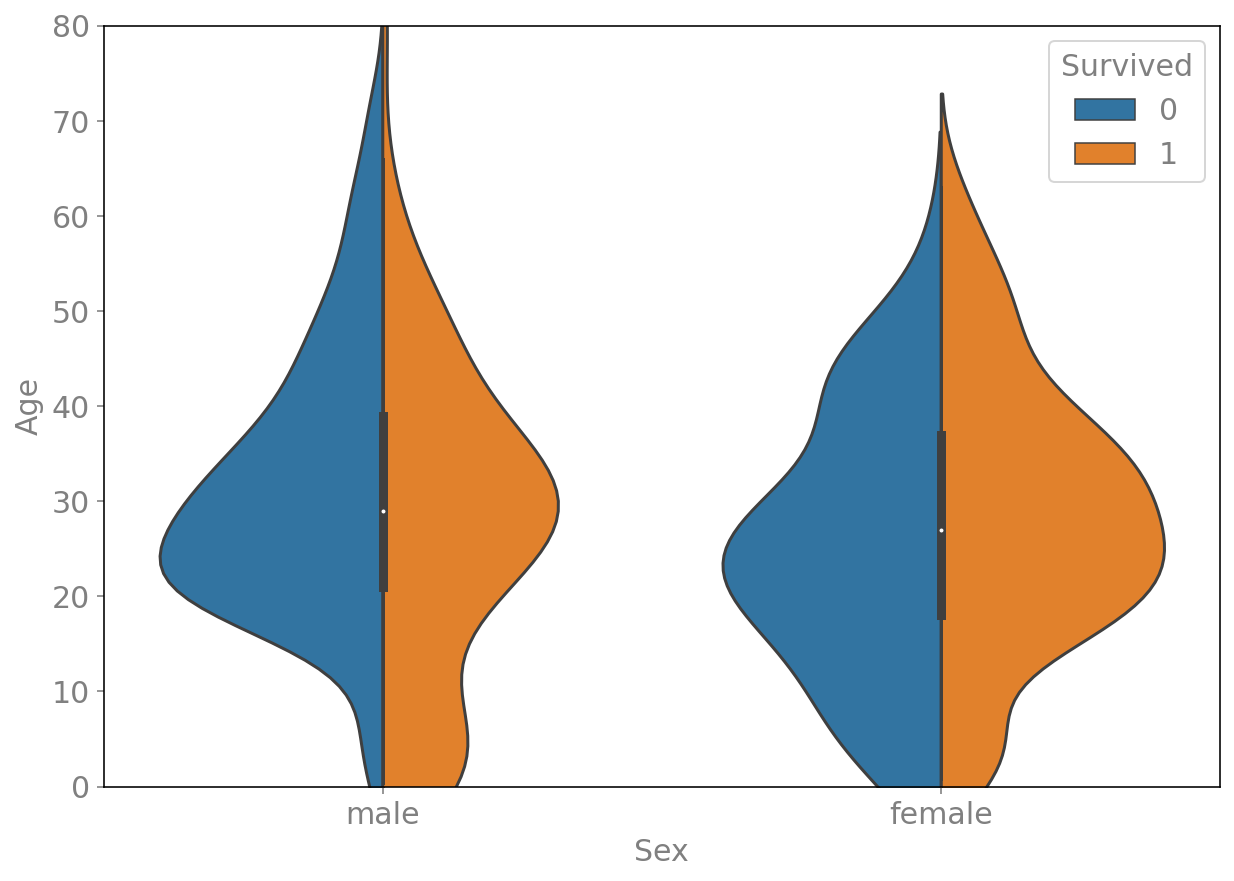

In [40]:
plt.figure(figsize=(10, 7))
sn.violinplot(data=train, x='Sex', y='Age', hue='Survived', split=True).set(ylim=(0, train['Age'].max()))

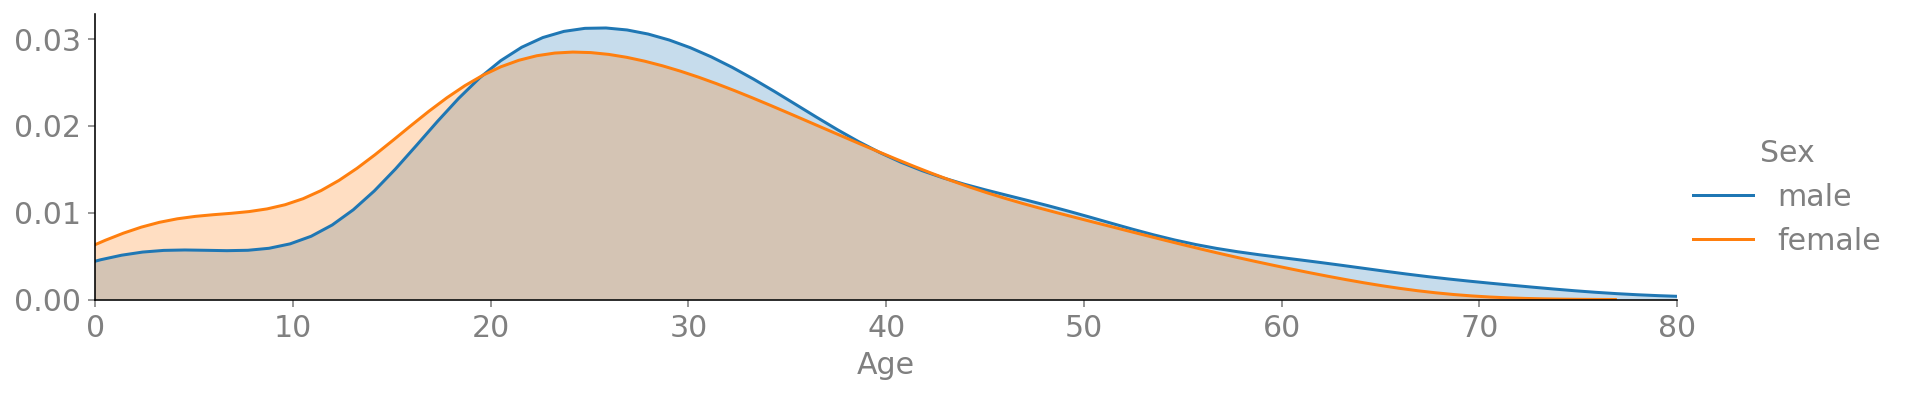

In [41]:
facet = sn.FacetGrid(train, hue="Sex", aspect=4)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
facet.set(xlim=(0, train['Age'].max()))

Age가 20전으로 female이 더 많고 20부터 40전까지는 male이 많다가 그 후로는 비슷하다.

[(0.0, 80.0)]

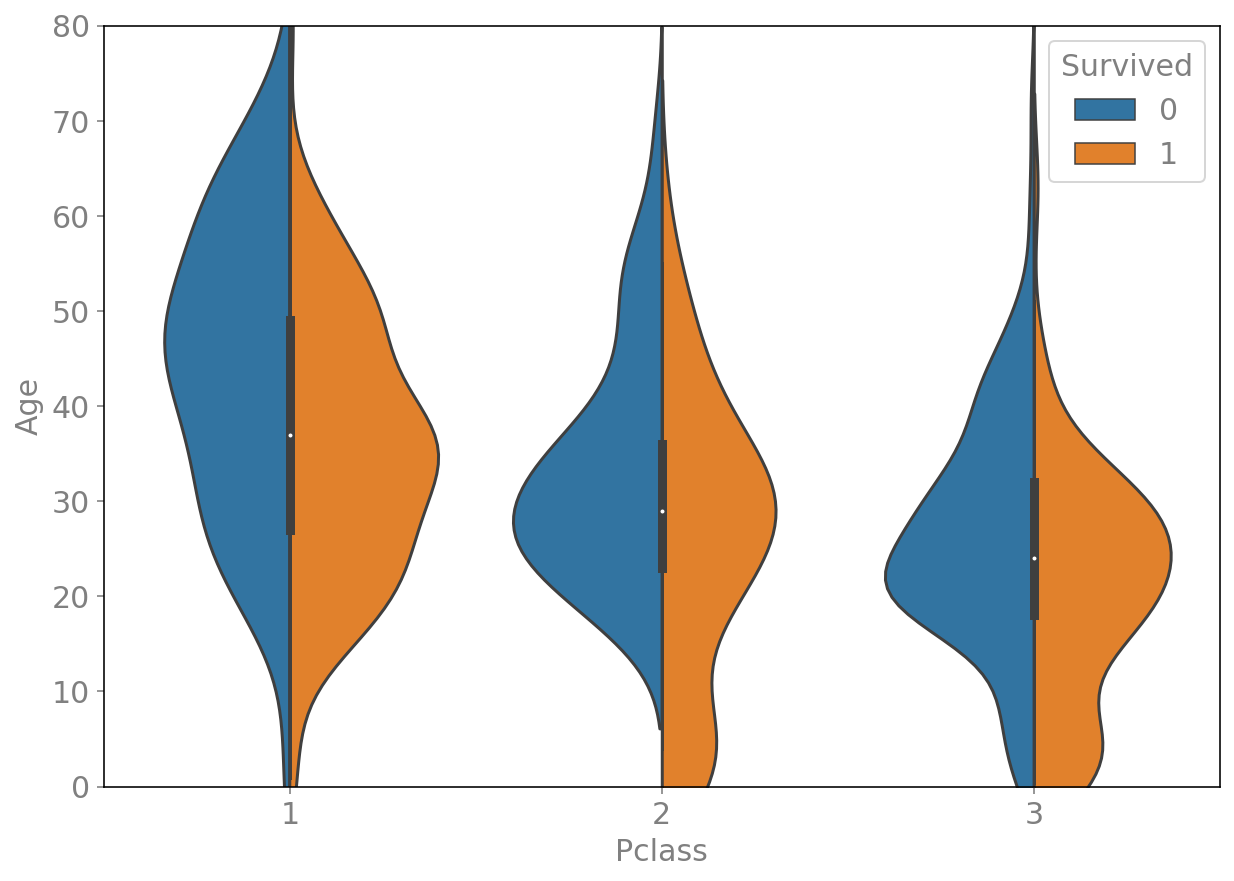

In [42]:
plt.figure(figsize=(10, 7))
sn.violinplot(data=train, x='Pclass', y='Age', hue='Survived', split=True).set(ylim=(0, train['Age'].max()))

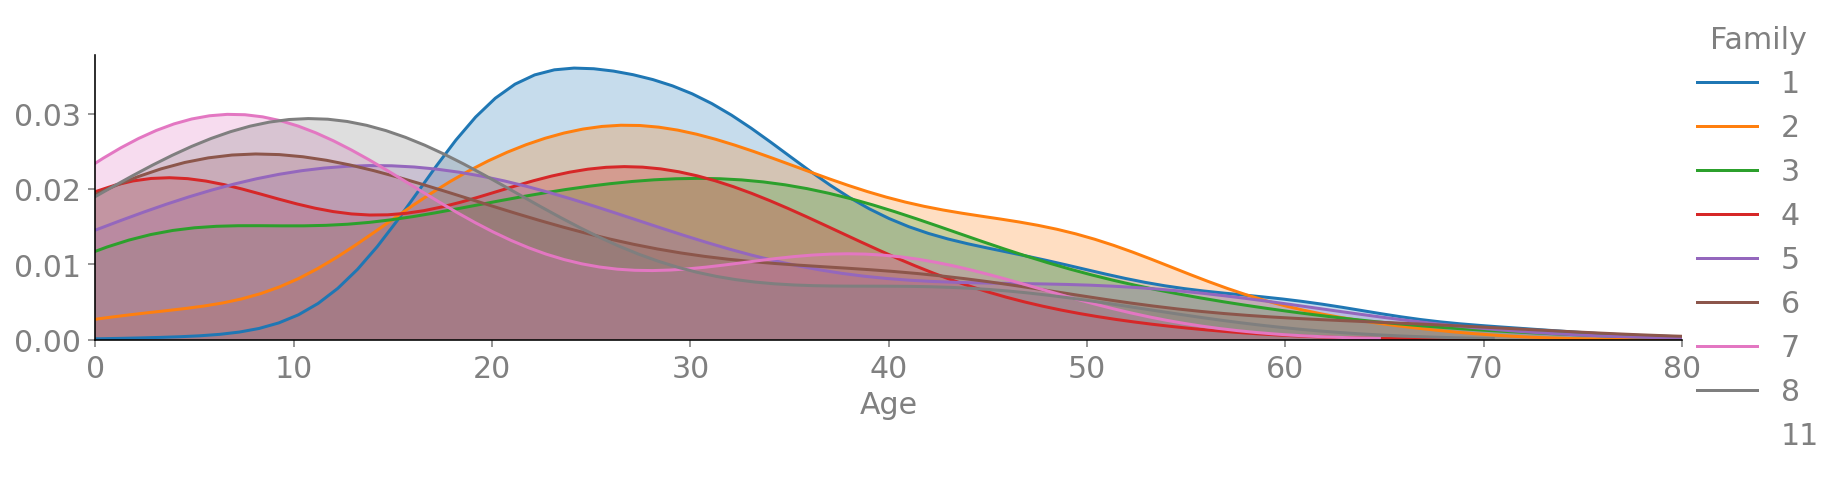

In [43]:
facet = sn.FacetGrid(train, hue="Family", aspect=4)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
facet.set(xlim=(0, train['Age'].max()))

Family별로 그래프가 다른 것을 알 수 있다.

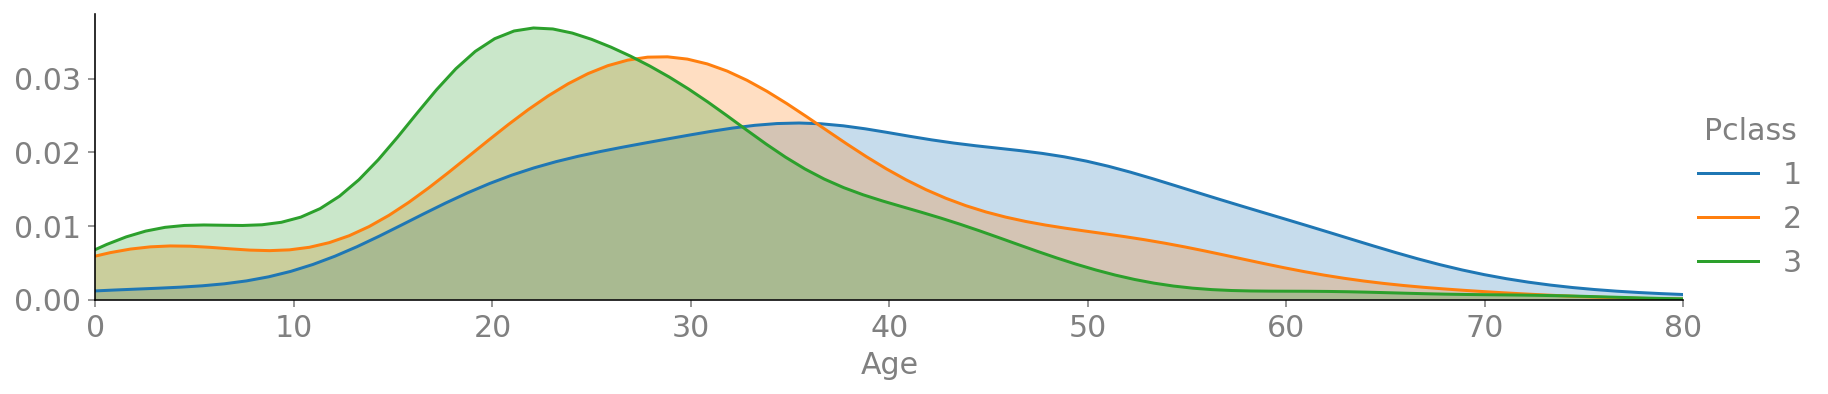

In [44]:
facet = sn.FacetGrid(train, hue='Pclass', aspect=4)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
facet.set(xlim=(0, train['Age'].max()))

Pclass별로 그래프가 다른 것을 알 수 있다.

In [45]:
print('Median for Age seperated by Pclass : ')
display(train.groupby(['Pclass', 'Sex', 'Family'])['Age'].median())

Median for Age seperated by Pclass : 


Pclass  Sex     Family
1       female  1         32.50
                2         35.00
                3         39.00
                4         19.50
                5         19.50
                6         23.50
        male    1         45.00
                2         37.00
                3         49.00
                4         11.00
                6         41.50
2       female  1         32.25
                2         28.00
                3         24.50
                4         24.00
                5         54.00
                6         24.00
        male    1         30.00
                2         32.50
                3         19.00
                4         24.00
3       female  1         22.00
                2         20.00
                3         27.00
                4          5.00
                5         15.00
                6         39.00
                7         10.00
                8         29.50
                11          NaN
        male    1

In [46]:
train[train['Family']==11]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin category,Family,Family_tmp
PassengerId,,,,,,,,,,,,,,
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,11,3


In [47]:
display(train.groupby(['Pclass', 'Sex', 'Family']).count()['Survived'])

Pclass  Sex     Family
1       female  1          34
                2          39
                3          13
                4           4
                5           2
                6           2
        male    1          75
                2          31
                3          11
                4           3
                6           2
2       female  1          32
                2          19
                3          14
                4           9
                5           1
                6           1
        male    1          72
                2          15
                3          17
                4           4
3       female  1          60
                2          29
                3          22
                4           6
                5           9
                6           5
                7           8
                8           2
                11          3
        male    1         264
                2          28
                3

Pclass, Sex, Family에 따라 데이터를 묶으면 30개의 데이터가 안 되는 그룹이 상당히 많이 생긴다. 이 경우, 평균이나 중간값이 그 그룹을 대표하는 값으로서 타당할지 의문이 생긴다. 그래도 진행하겠다. Pclass, Sex, Family로 나눈 그룹별로 중간값을 산출하여 결측치를 채우겠다. 그룹을 세부화하다 보니 Age값이 아예 없는 그룹도 발생한다. 이 경우 상위 그룹인 Pclass, Sex를 바탕으로 중간값을 주겠다.

In [48]:
train['Age'] = train.groupby(['Pclass', 'Sex', 'Family'])['Age'].apply(lambda x: x.fillna(x.median()))
train['Age'] = train.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

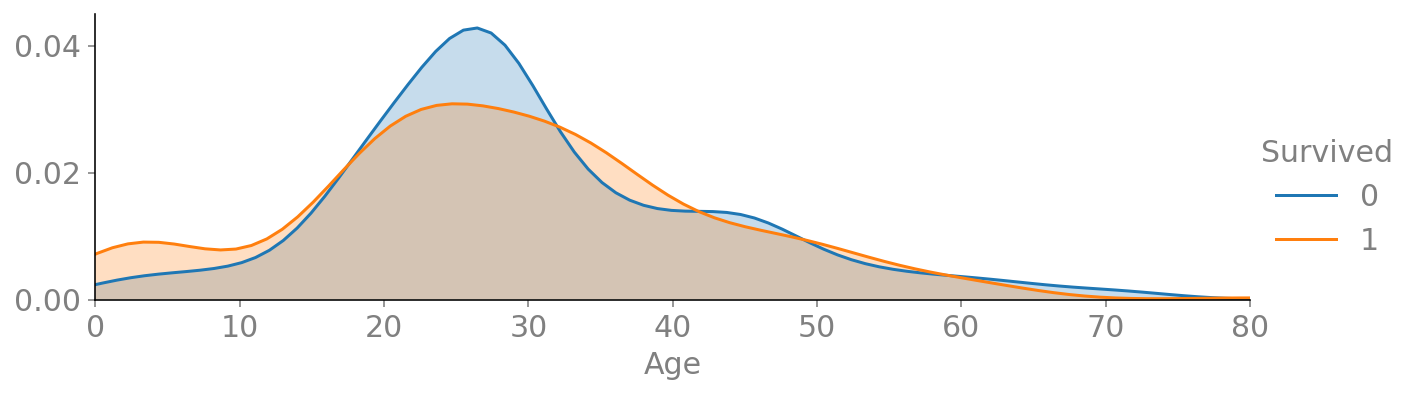

In [49]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
facet.set(xlim=(0, train['Age'].max()))

(0.0, 0.025)

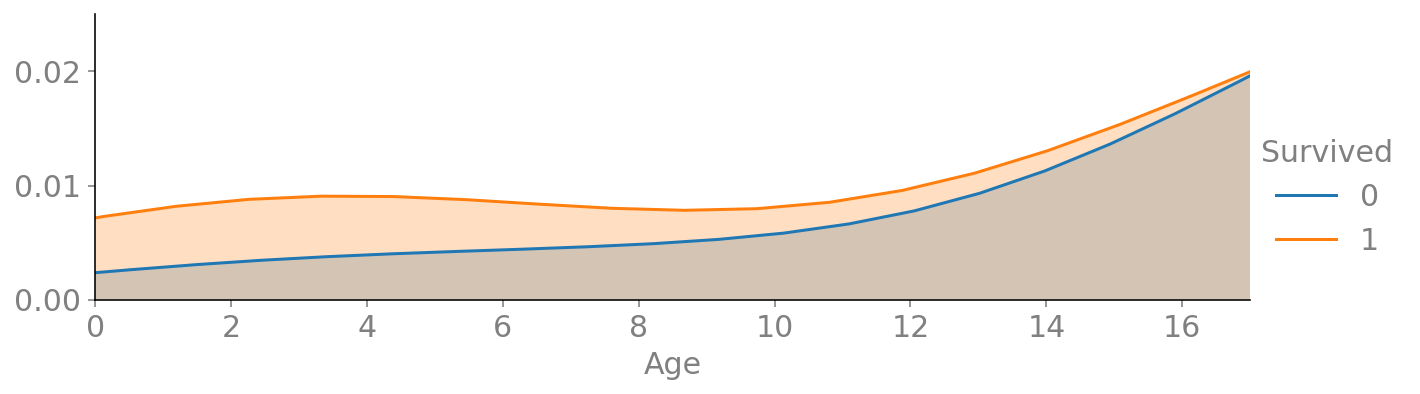

In [50]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
plt.xlim(0,17)
plt.ylim(0, 0.025)

(17.0, 32.0)

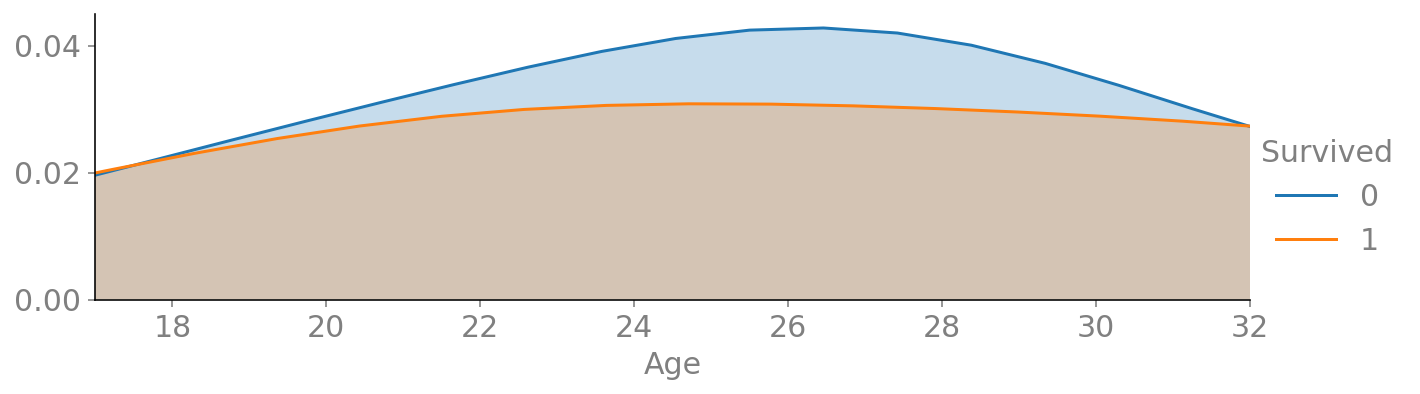

In [51]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
plt.xlim(17, 32)

(0.0, 0.03)

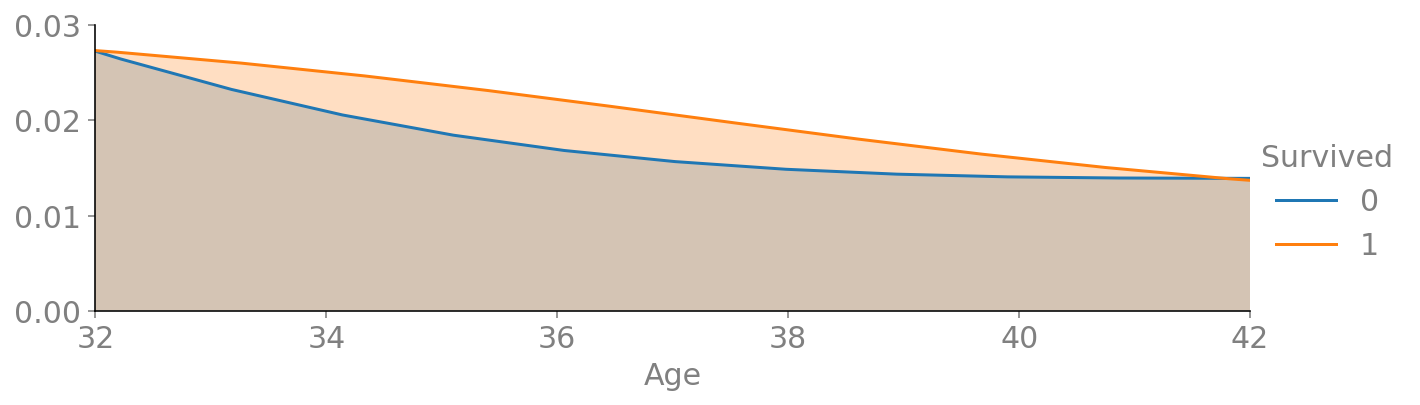

In [52]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
plt.xlim(32, 42)
plt.ylim(0,0.03)

(0.0, 0.015)

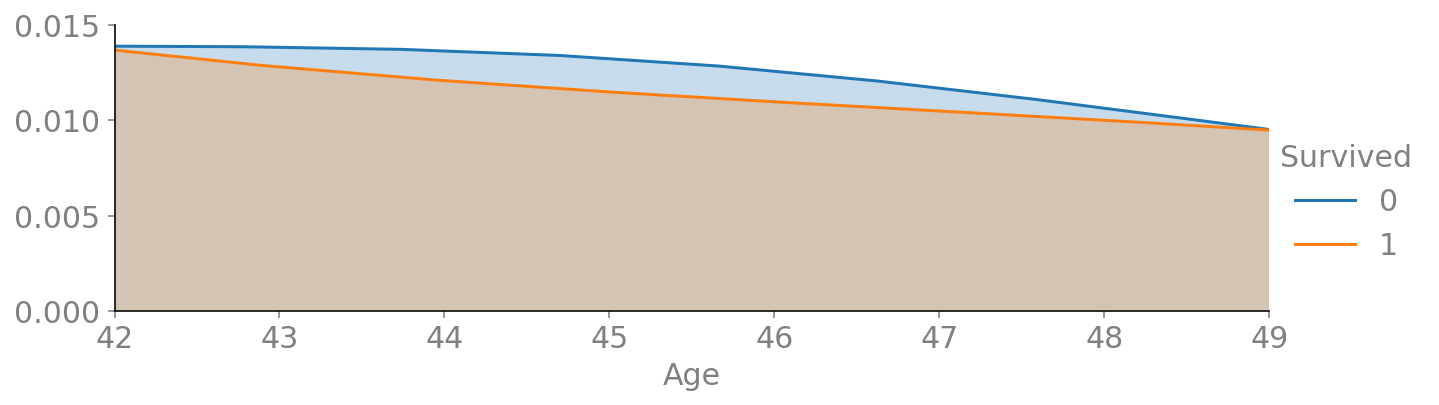

In [53]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
plt.xlim(42, 49)
plt.ylim(0,0.015)

(0.0, 0.01)

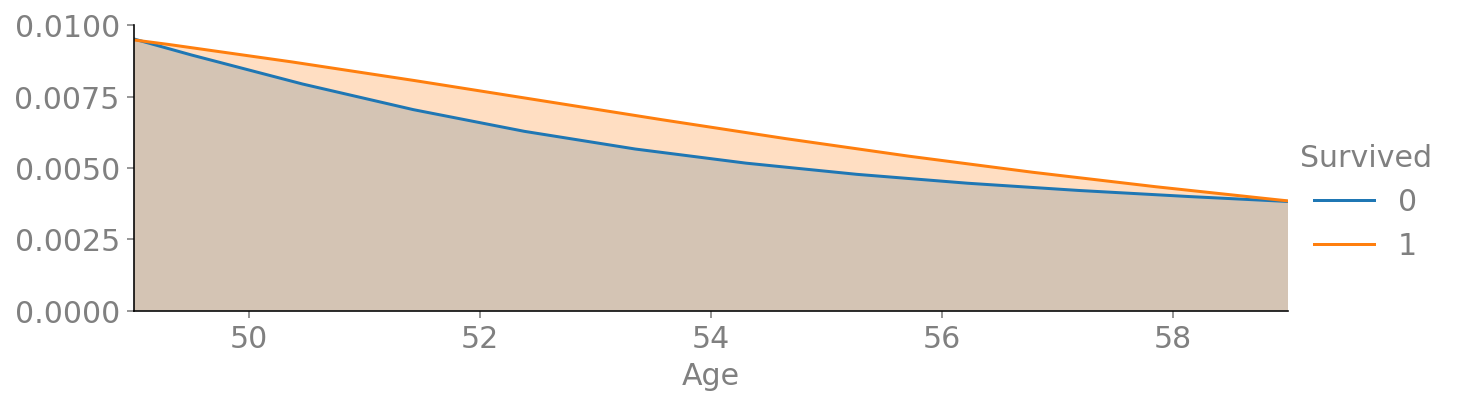

In [54]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
plt.xlim(49, 59)
plt.ylim(0, 0.01)

(0.0, 0.004)

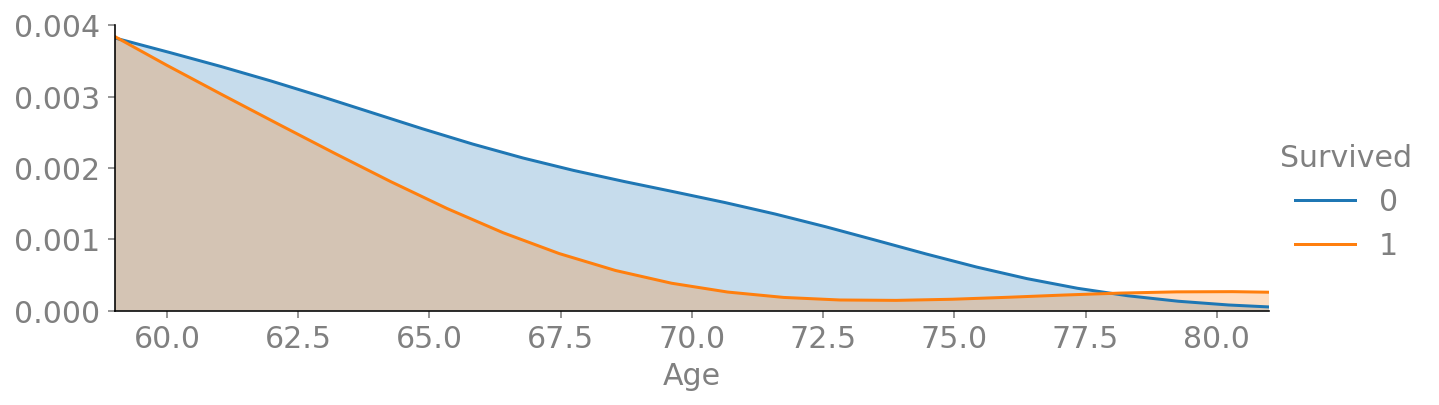

In [55]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Age', shade=True).add_legend()
plt.xlim(59, train['Age'].max()+1)
plt.ylim(0, 0.004)

사실 Age => 42에서 Survived비율은 노이즈가 있다고 할 수 있을만큼 0과 1의 차이가 매우 작다.
우선 Age를 6개의 category로 나누지만 4개로 나누는 것도 고려해볼만 할 것 같다.

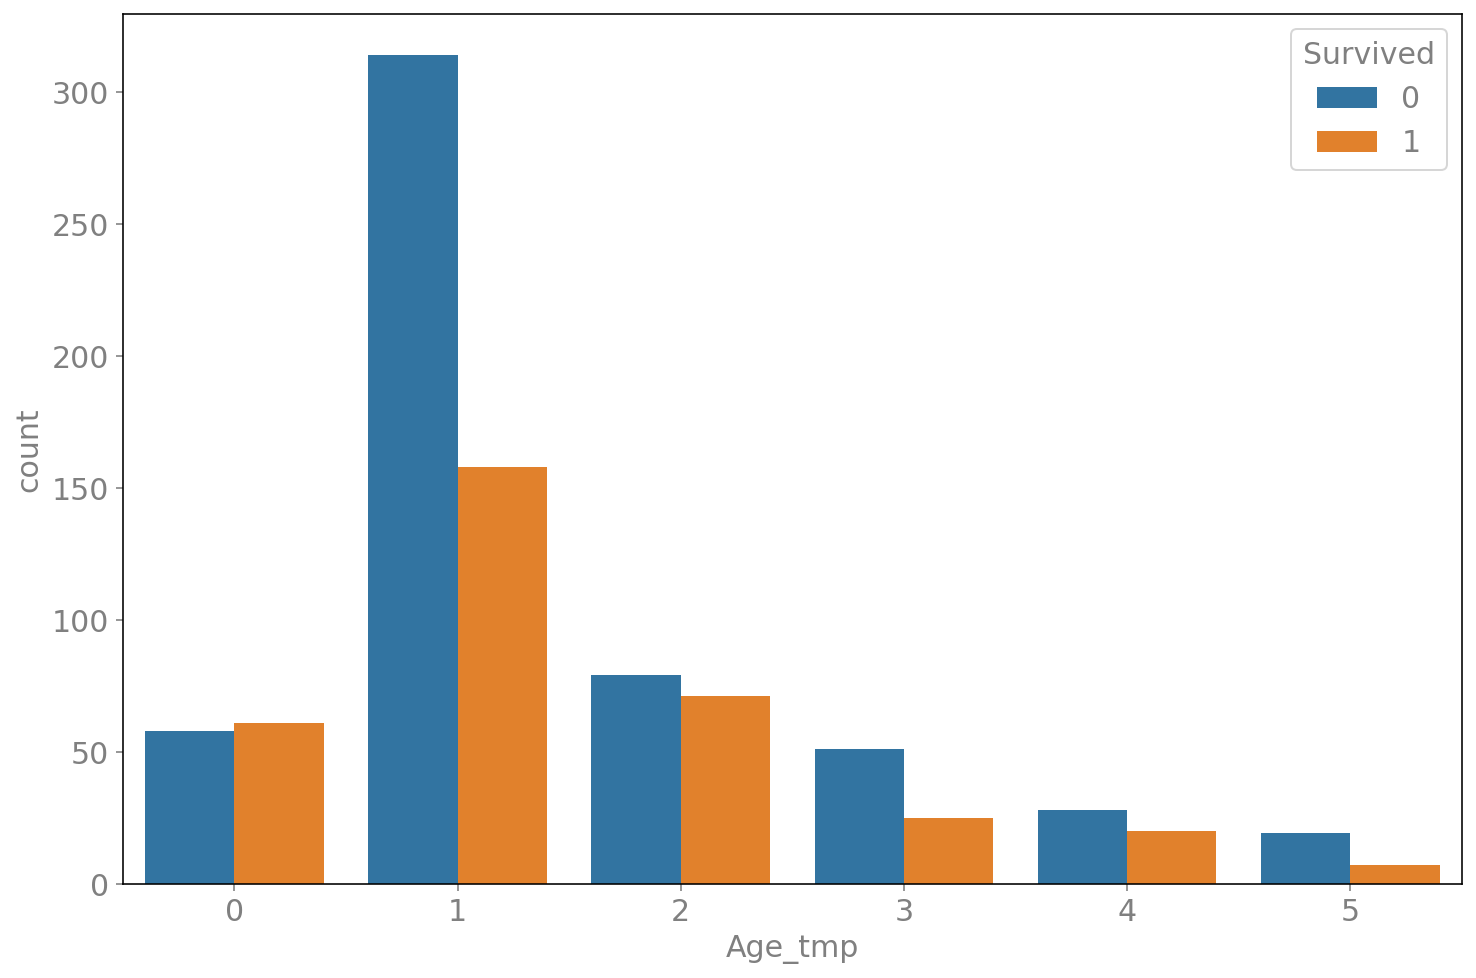

In [56]:
train['Age_tmp'] = pd.cut(x=train['Age'], bins=[0.0, 17.0, 32.0, 42.0, 49.0, 59.0, train['Age'].max()], labels=[0, 1, 2, 3, 4, 5])
#train['Age_tmp'] = pd.cut(x=train['Age'], bins=[0.0, 17.0, 32.0, 42.0, train['Age'].max()], labels=[0, 1, 2, 3])
plt.figure(figsize=(12,8))
sn.countplot(data=train, x='Age_tmp', hue='Survived')
plt.show()
#hue_chart(train, 'Age_tmp')

In [57]:
train[(train['Age'] > 32) & (train['Age'] <= 42)]['Survived'].value_counts()

0    79
1    71
Name: Survived, dtype: int64

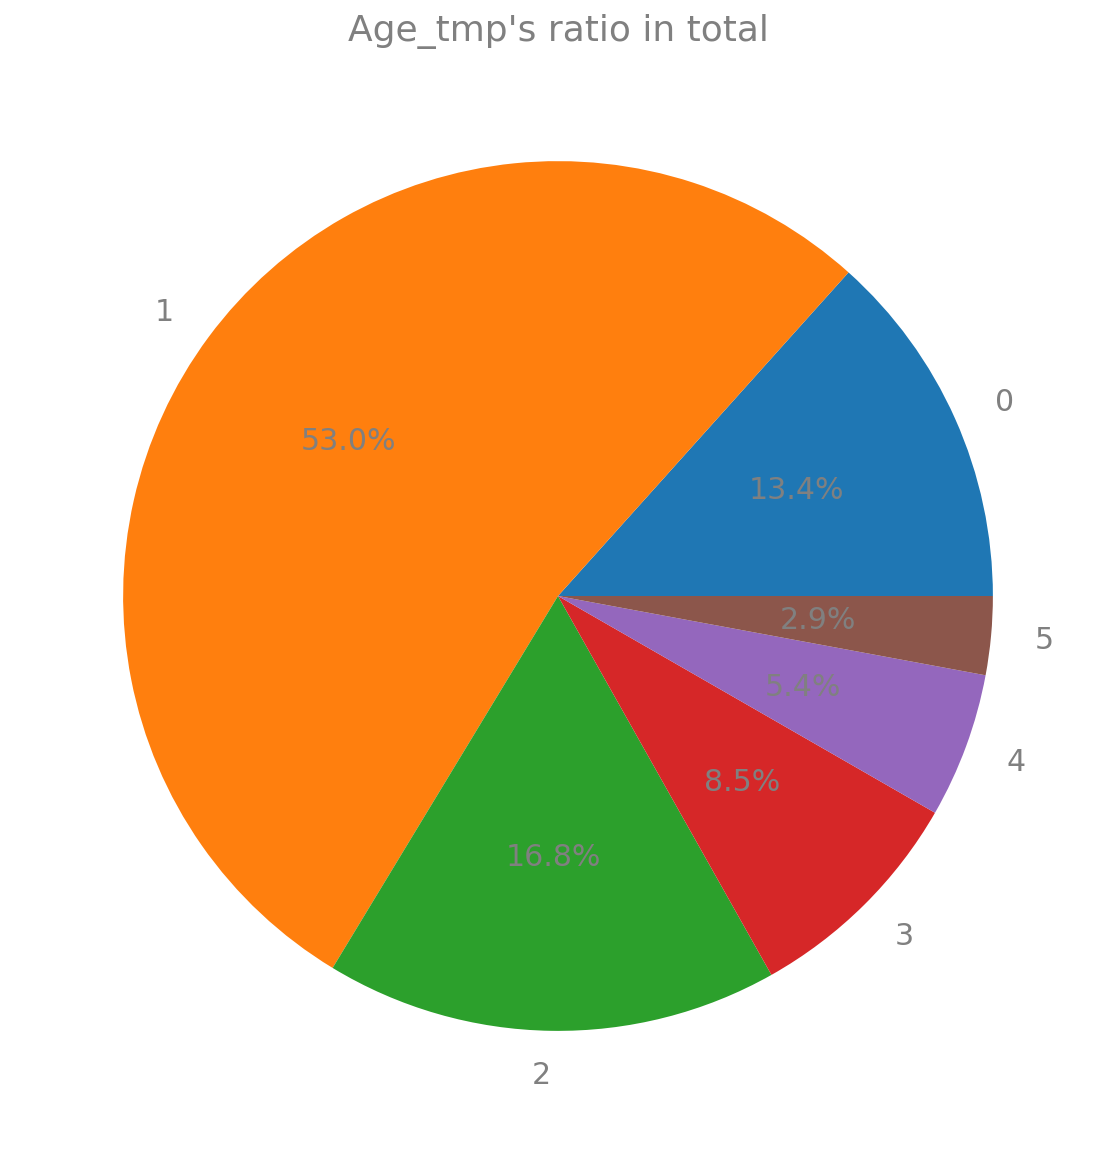

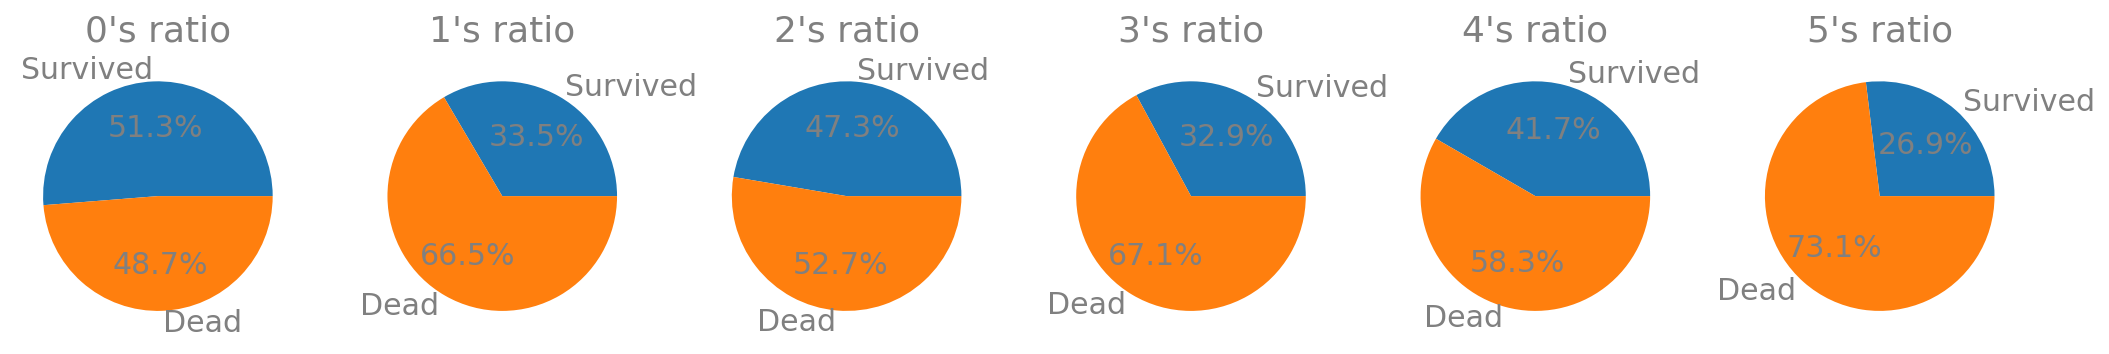

In [58]:
pie_chart(train, 'Age_tmp')

<del>생존률이 50%를 지나는 곳들을 포인트로 하여 구간을 산출</del>(50%에 가까운 것이지 반드시 50%는 아니다. KDE밀도추정그래프는 연속형 데이터의 분포추세를 나타낸 것이지 전체 데이터 개수를 내포하는 것은 아니다). 이를 바탕으로 Age를 연속형에서 범주형으로 변환했다.<br>
관찰 결론 : 어린 아이들의 나이와 그의 부모들의 나이 즈음의 생존률이 다른 구간에 비해 높다.<br>
Q. 연속형 데이터을 이산적인 범주형 데이터로 변환함으로써 생기는 결과는? <br>
A. 단일성 분포의 왜곡을 막을 수 있지만, 이산화를 통한 데이터의 손실이라는 단점 존재한다.

train data에는 Fare의 결측치가 없지만 test data에는 결측치가 1개 있다. 

<Figure size 2880x1440 with 0 Axes>

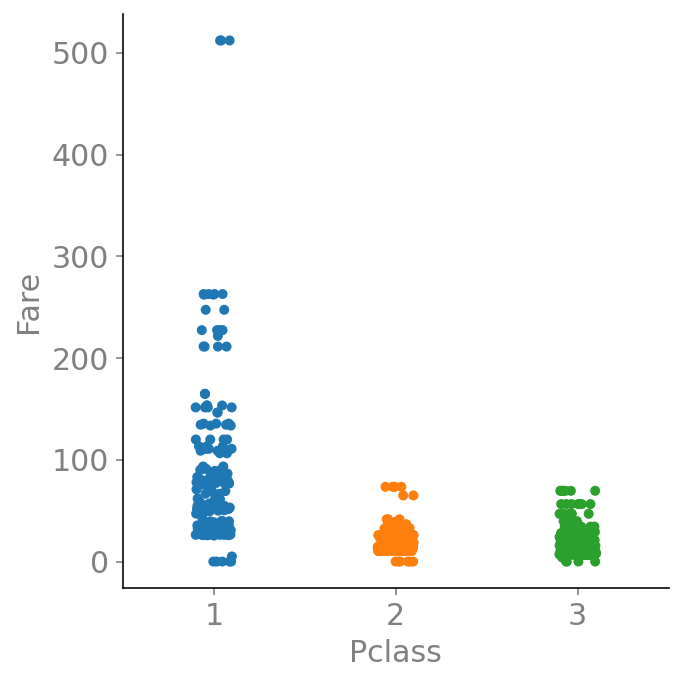

In [59]:
plt.figure(figsize=(40, 20))
sn.catplot(data=train, x='Pclass', y='Fare')

Fare측면에서 1등석과 2등석의 차이는 커 보이지만 2등석과 3등석의 큰 차이가 없어 보일 수 있다.

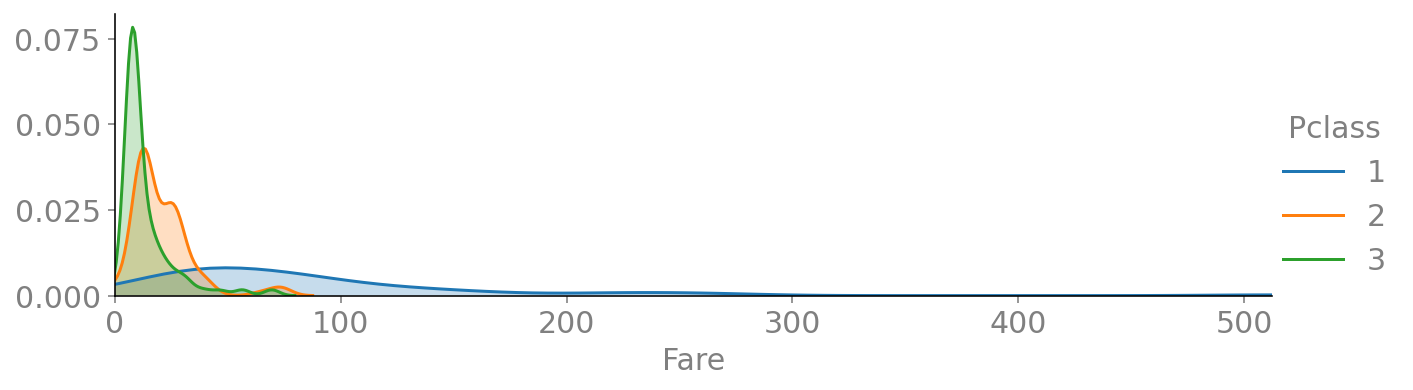

In [60]:
facet = sn.FacetGrid(train, hue="Pclass", aspect=3)
facet.map(sn.kdeplot, 'Fare', shade=True).add_legend()
facet.set(xlim=(0, train['Fare'].max()))

In [61]:
train['Pclass'].value_counts().sort_index()

1    216
2    184
3    491
Name: Pclass, dtype: int64

In [62]:
train[train['Fare']>60]['Pclass'].value_counts().sort_index()

1    108
2      7
3      7
Name: Pclass, dtype: int64

특정 값 이상의 Fare를 기준으로 볼 때 2등급의 비율이 3등급의 비율보다 2.5배 이상 높음을 알 수 있다. <br>
Fare의 분포가 클래스별로 다르다는 것을 알 수 있습니다. <br> 
만약 결측치가 있다면 Pclass별 (중앙값보다) 평균값을 부여하는 게 좋을 것 같다.

train data에서 Fare의 결측치는 없지만 test data에서 Fare의 결측치는 1개 있다.

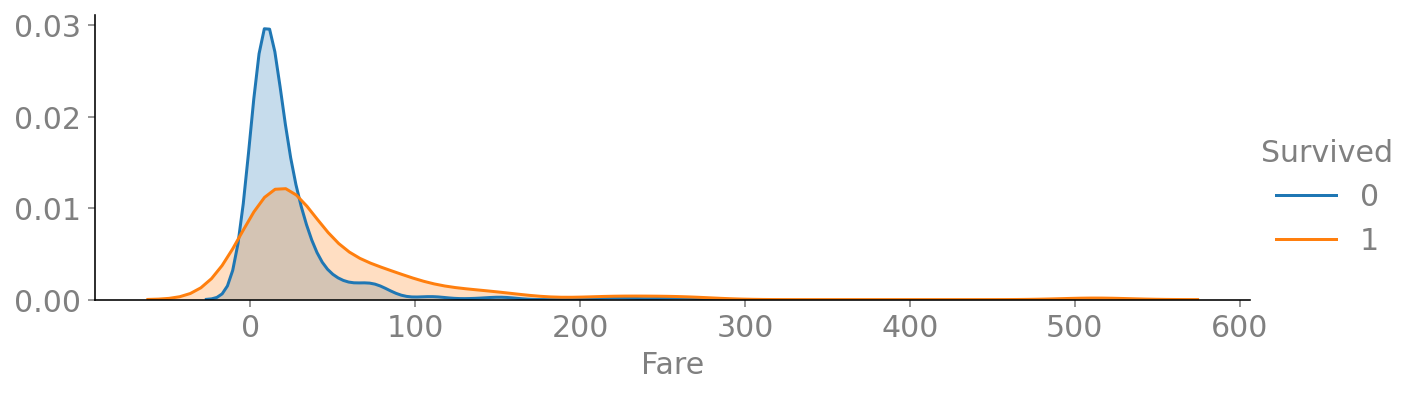

In [63]:
facet = sn.FacetGrid(train, hue="Survived", aspect=3)
facet.map(sn.kdeplot, 'Fare', shade=True).add_legend()

(0.0, 29.5)

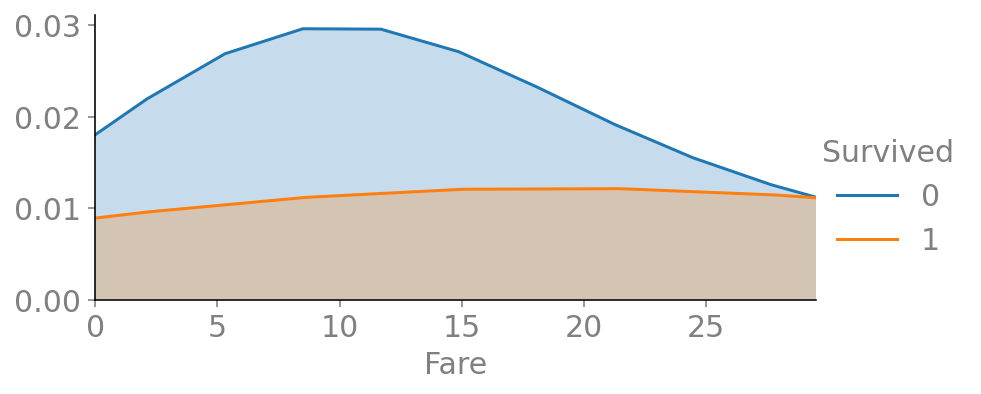

In [64]:
facet = sn.FacetGrid(train, hue="Survived", aspect=2)
facet.map(sn.kdeplot, 'Fare', shade=True).add_legend()
plt.xlim(0,29.5)

(0.0, 0.012)

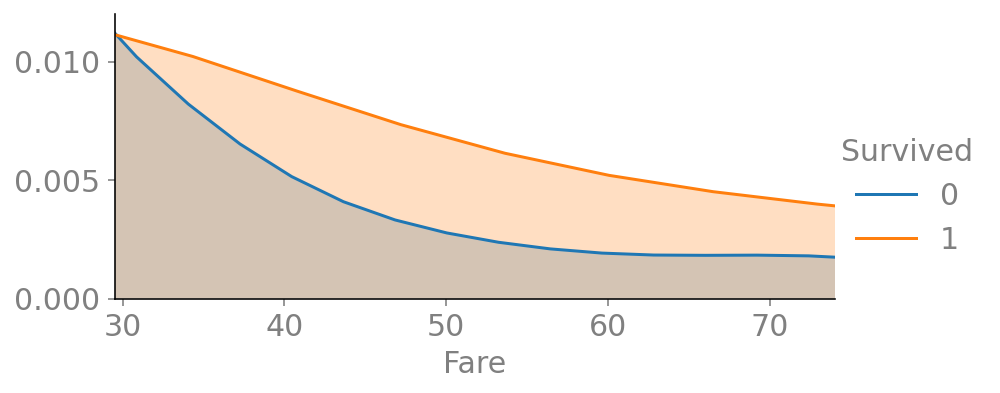

In [65]:
facet = sn.FacetGrid(train, hue="Survived", aspect=2)
facet.map(sn.kdeplot, 'Fare', shade=True).add_legend()
plt.xlim(29.5, 74)
plt.ylim(0,0.012)

(0.0, 0.004)

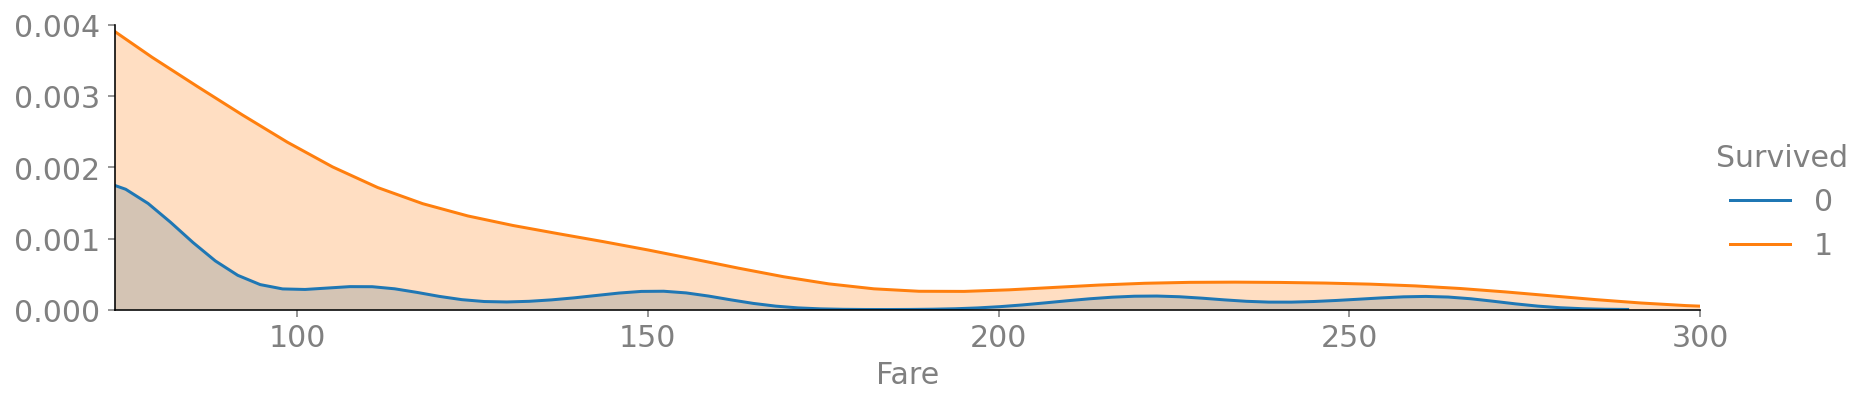

In [66]:
facet = sn.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sn.kdeplot, 'Fare', shade=True).add_legend()
plt.xlim(74, 300)
plt.ylim(0,0.004)

<Figure size 864x576 with 0 Axes>

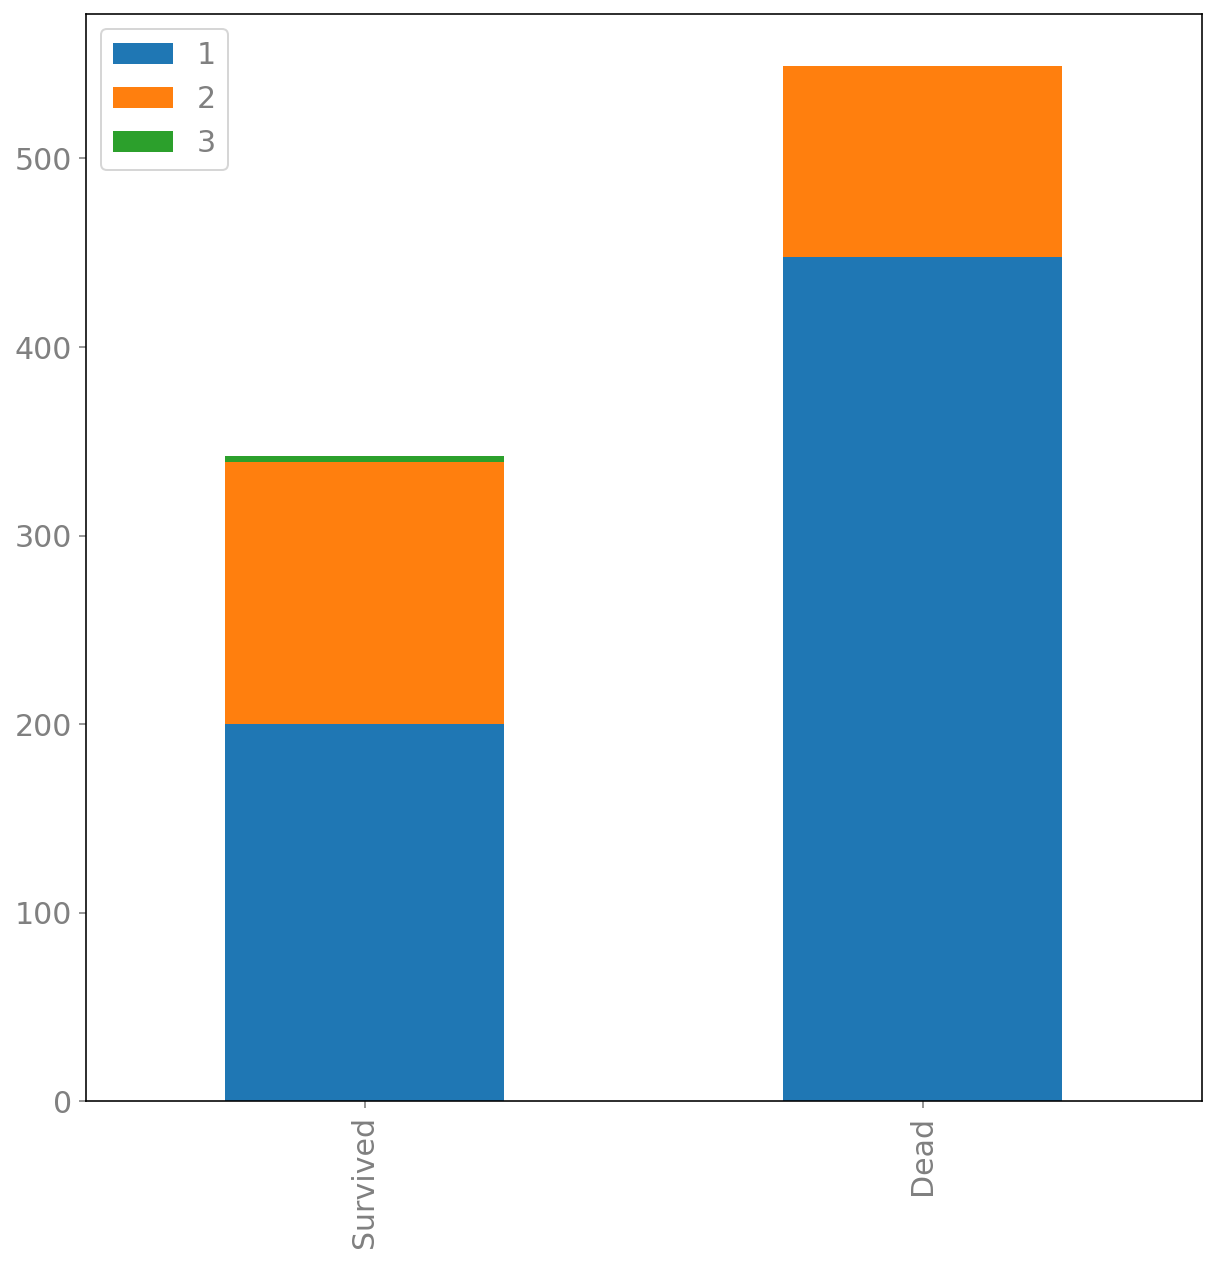

In [67]:
train['Fare_tmp'] = pd.cut(x=train['Fare'], bins=[-1e-8, 29.5, 300, train['Fare'].max()], labels=[1, 2, 3])
plt.figure(figsize=(12,8))
bar_chart(train, 'Fare_tmp')
plt.show()

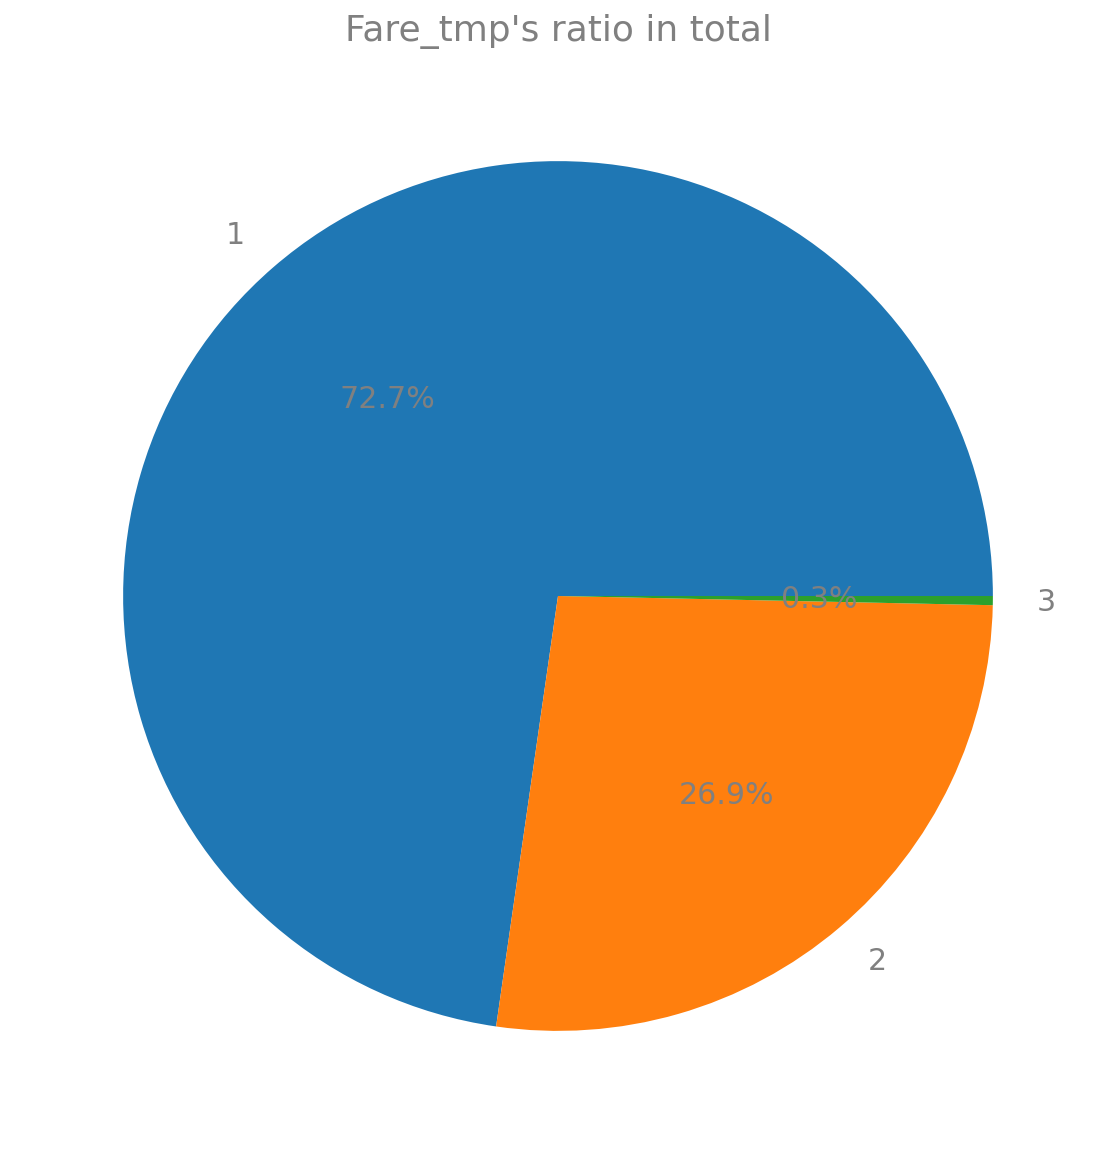

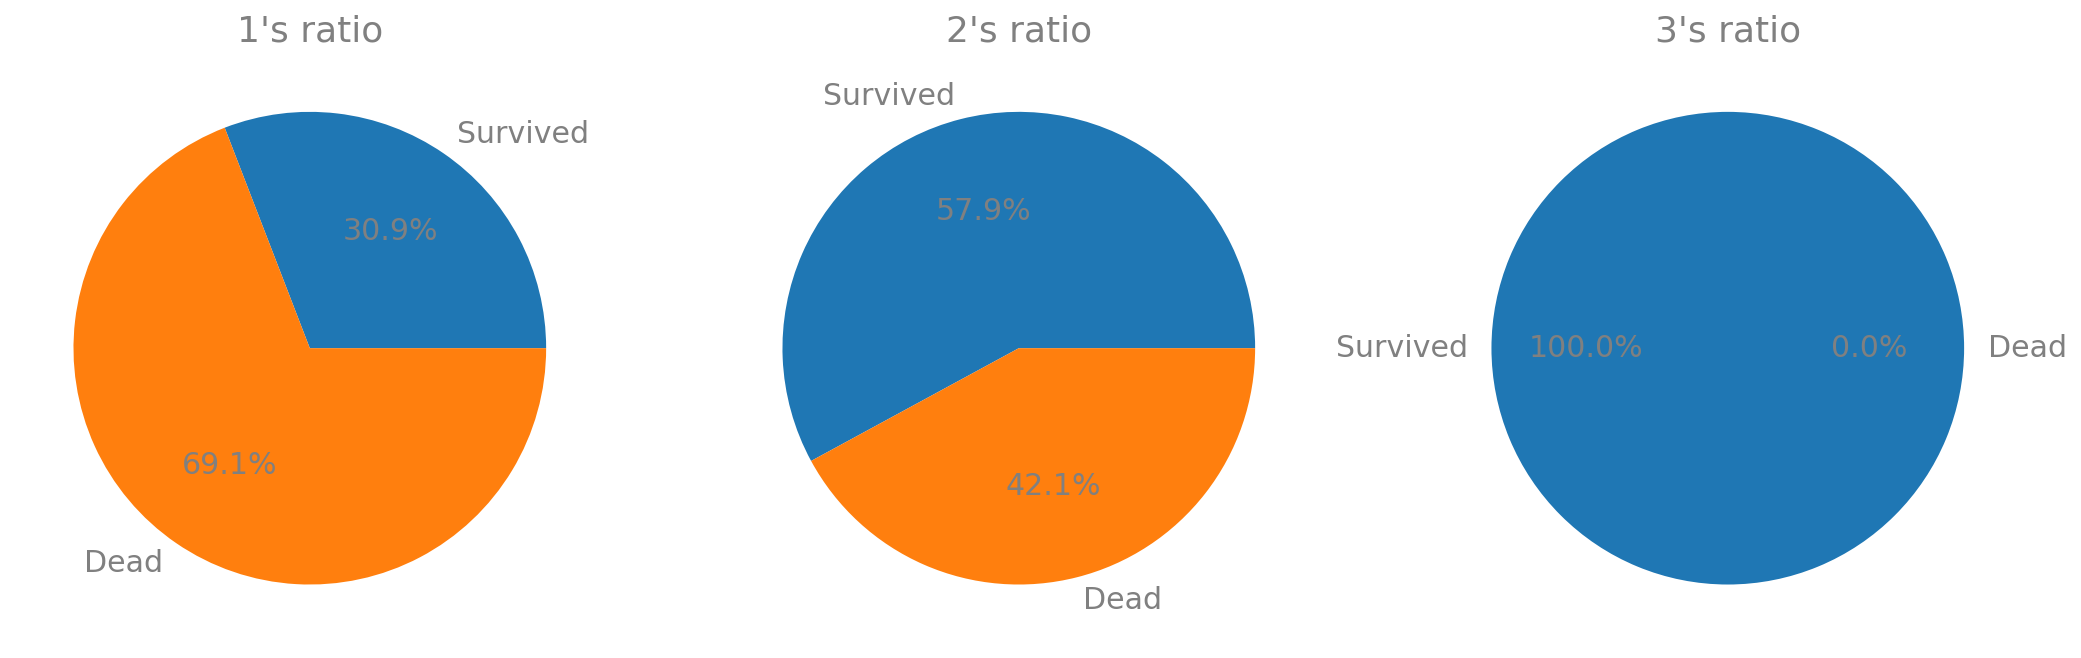

In [68]:
feature_ratio = train['Fare_tmp'].value_counts(sort=False)#.sort_index()
feature_size = feature_ratio.size
feature_index = feature_ratio.index
survived = train['Survived'].eq(1).groupby(train['Fare_tmp']).sum()
dead = train['Survived'].eq(0).groupby(train['Fare_tmp']).sum()
    
plt.figure(figsize=(10,10))
plt.plot(aspect='auto')
plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
plt.title('Fare_tmp' + '\'s ratio in total')
plt.show()
    
f, axs = plt.subplots(1, len(feature_index), figsize=(18, 18))
for i, index in enumerate(feature_index):
    plt.subplot(1, feature_size, i+1, aspect='equal')
    plt.pie(x=[survived[index-1], dead[index-1]], labels=['Survived', 'Dead'], autopct='%1.1f%%')
    plt.title(str(index)+'\'s ratio')

Pclass와 Fare는 둘 다 사회적 경제적 지위를 의미한다. <br>
두 feature를 하나의 feature로 만드는 게 좋을 것 같다는 생각이 든다. <br>
Class = Fare/Pclass

## Step3. Feature Engineering 
feature engineering은 데이터에 대한 도메인 지식을 사용하여 기계 학습 알고리즘에 사용할 feature vectors를 만드는 과정이다. feature vector는 어떠한 object를 나타내는 숫자 형상의 n차원 벡터다. 머신 러닝에 있어 많은 알고리즘은 object들의 수치적 표현을 필요로 한다. 왜냐하면 그러한 표현은 컴퓨터 입장에서 처리와 통계 분석을 용이하게 하기 때문이다.

In [5]:
def numerical_Sex(data):
    data['Sex'] = data.apply(lambda x : 0 if x['Sex']=='male' else 1, axis=1)

In [6]:
def fillna_Embarked(data):
    data['Embarked'] = data['Embarked'].fillna('S')

In [7]:
def numerical_Embarked(data):
    data['Embarked'] = data['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2})

In [8]:
def make_Family(data):
    data['Family']=data['SibSp']+data['Parch']+1

In [9]:
def category_Family(data):
    data['Family'] = pd.cut(x=data['Family'], bins=[0, 2, 5, 8, 12], labels=[0, 1, 2, 3])

In [10]:
def fillna_Age(data):
    data['Age'] = data.groupby(['Pclass', 'Sex', 'Family'])['Age'].apply(lambda x: x.fillna(x.median()))
    data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [39]:
"""Age를 6개로 분류했을 때보다 4개로 분류했을 때 1%정도 더 잘 예측하는 것 같아 4개로 분류했다.
   사실 1%이면 오차범위에서 거의 동일할 것지만 말이다."""
def category_Age(data):
    #data['Age'] = pd.cut(x=data['Age'], bins=[-1e-8, 18, 32, 41, 49, 59, data['Age'].max()+1], labels=[0, 1, 2, 3, 4, 5])
    data['Age'] = pd.cut(x=data['Age'], bins=[-1e-8, 17.0, 32.0, 42.0, data['Age'].max()], labels=[0, 1, 2, 3])

In [12]:
def fillna_Fare(data):
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [98]:
def category_Fare(data):
    data['Fare'] = pd.cut(x=data['Fare'], bins=[-1e-8, 29.5, 300, data['Fare'].max()+1], labels=[1, 2, 3])

In [14]:
def make_Class(data):
    data['Class']=data['Fare'].astype(float)/data['Pclass']

In [99]:
def preprocessing(data):
    numerical_Sex(data)
    fillna_Embarked(data)
    numerical_Embarked(data)
    make_Family(data)
    category_Family(data)
    fillna_Age(data)
    category_Age(data)
    fillna_Fare(data)
    category_Fare(data)
    make_Class(data)

In [100]:
train = pd.read_csv('train.csv', index_col='PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
X = train[['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch','Age', 'Fare']]
y = train[['Survived']]

In [102]:
preprocessing(X)

In [103]:
X = X[['Sex', 'Embarked', 'Age', 'Family', 'Class']]

Model마다 다르지만 feature scale에 민감할 수 있으므로 feature값을 정규화해준다.

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_rescale = scaler.fit_transform(X)

## Step4. Model Selection
일반적으로 성능이 뛰어나다고 여겨지는 모델들이 있다. 하지만 data마다 model의 성능은 다를 수 있으므로 이를 확인하고 model을 선택해야 한다.

PrintScores, myPrintScores함수 모두 cross validation을 위한 함수로 동일한 함수이다. <br>
차이점은 myPrintScores는 sklearn의 method인 cross_val_score을 사용하지 않고 train data를 K-Fold로 나누고 cross validating하기때문에 세부적인 tuning을 할 수 있다. <del>stacking을 위해 만들었지만 정작 stacking을 못했다.</del>


In [105]:
def PrintScores(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=8, scoring='accuracy')
    # numpy float 출력옵션 변경
    np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})
    print(scores)
    print(round(np.mean(scores),3), round(np.std(scores),3))

In [170]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [171]:
def myPrintScores(model, X, y):
    if not isinstance(X, np.ndarray):
        X_train = X.to_numpy()
    else:
        X_train = X
    if not isinstance(y, np.ndarray):
        y_train = y.to_numpy()
    else:
        y_train = y
    y_train = y_train.flatten()
    scores = []
    skfolds = StratifiedKFold(n_splits=8, shuffle=True)

    for train_index, test_index in skfolds.split(X_train, y_train):
        clone_clf = clone(model)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        score = n_correct / len(y_pred)
        scores.append(score)
    
    print(np.round(scores,3))
    print(round(np.mean(scores), 3), round(np.std(scores), 3))

### 4-1 Cross Validation Single Models without using Ensemble
앙상블 기법을 사용하지 않고 단일모델에 대하여 cross validation을 해봤다.

In [150]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
myPrintScores(log_clf, X_rescale, y)

[0.821 0.804 0.759 0.757 0.793 0.793 0.757 0.82 ]
0.788 0.026


In [151]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors = 5)
myPrintScores(knn_clf, X_rescale, y)

[0.839 0.786 0.804 0.856 0.712 0.802 0.82  0.811]
0.804 0.04


In [152]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svm_rbf_clf = SVC(kernel='rbf', gamma=0.1, C=10, probability=True)
myPrintScores(svm_rbf_clf, X_rescale, y)

[0.786 0.812 0.821 0.802 0.802 0.802 0.802 0.793]
0.802 0.01


In [153]:
svm_poly_clf = SVC(kernel='poly', degree=2, coef0=1, C=5, probability=True)
myPrintScores(svm_poly_clf, X_rescale, y)

[0.759 0.839 0.768 0.784 0.793 0.784 0.829 0.784]
0.792 0.026


In [154]:
svm_clf = SVC(probability=True)
myPrintScores(svm_clf, X_rescale, y)

[0.893 0.795 0.804 0.856 0.811 0.775 0.784 0.766]
0.81 0.041


In [155]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=7, min_samples_split=18)
myPrintScores(tree_clf, X, y)

[0.768 0.821 0.795 0.802 0.865 0.82  0.82  0.802]
0.812 0.026


## 4-2 Ensemble
Random Forest, Bagging, Voting, Boosting 등 앙상블기법을 이용해보자.

In [173]:
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [163]:
forest_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=100) 
#단일 Decision Tree가 high variance한 경향을가지도록 max_depth=100으로 설정하였다. 
#이렇게 하여도 많은 수의 나무가 다시금 bias를 높일 것이라 판단하여 오히려 더 좋은 성능을 내지 않을까 싶었다.
#실제로 max_depth=10, min_samples_split=20일 때보다 성능이 조금더 좋아진 것 같다.
myPrintScores(forest_clf, X, y)

[0.839 0.866 0.759 0.811 0.838 0.82  0.802 0.739]
0.809 0.04


Boosting 방법 중 하나인 Extreme Gradient Boosting을 이용한 학습

In [169]:
xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', booster='gbtree', max_depth=1000, reg_lambda=3)
myPrintScores(xgb_clf, X_rescale, y)

[0.83  0.821 0.821 0.829 0.721 0.784 0.847 0.748]
0.8 0.042


위에서 보인 단일 모델들을 이용한 Soft Voting

In [174]:
voting_clf = VotingClassifier(
    estimators=[('svm_clf', svm_clf), 
                ('svm_rbf_clf', svm_rbf_clf), 
                ('svm_poly_clf', svm_poly_clf), 
                ('tree_clf', tree_clf), 
                ('knn_clf', knn_clf), 
                ('forest_clf', forest_clf), 
                ('xgb_clf', xgb_clf)],
    voting='soft')
myPrintScores(voting_clf, X_rescale, y)

[0.857 0.821 0.795 0.829 0.802 0.766 0.802 0.793]
0.808 0.026


각각의 단일 모델들에 대해 Bagging

In [179]:
rbf_SVM_bag_clf = BaggingClassifier(SVC(kernel='rbf', gamma=0.1, C=10, probability=True), 
                                    n_estimators=100, max_samples=0.2, bootstrap=True, n_jobs=-1)
myPrintScores(rbf_SVM_bag_clf, X_rescale, y)

[0.732 0.839 0.741 0.865 0.775 0.766 0.811 0.829]
0.795 0.045


In [181]:
poly_SVM_bag_clf = BaggingClassifier(SVC(kernel='poly', degree=2, coef0=1, C=5, probability=True), 
                                     n_estimators=100, max_samples=0.2, bootstrap=True, n_jobs=-1)
myPrintScores(poly_SVM_bag_clf, X_rescale, y)

[0.804 0.759 0.821 0.766 0.775 0.829 0.766 0.829]
0.793 0.028


In [182]:
KNN_bag_clf = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), 
                                     n_estimators=100, max_samples=0.2, bootstrap=True, n_jobs=-1)
myPrintScores(KNN_bag_clf, X_rescale, y)
"""
KNN은 가장 게으른 모델이라 불릴만큼 예측에 있어서 상당히 많은 시간을 사용한다.
mnist데이터 70000개를 이용해서 5-Folds 교차검증만 해봐도 실감할 것이다.
타이타닉 데이터는 1000개도 안 되니 걱정말고 사용할 수 있다.
"""

[0.759 0.777 0.83  0.784 0.82  0.73  0.829 0.802]
0.791 0.033


In [183]:
# Random Forest도 Bagging의 한 종류라서 한 번 더 추가해봤다.
forest_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1,max_depth=10, min_samples_split=20)
myPrintScores(forest_clf, X_rescale, y)

[0.839 0.821 0.812 0.811 0.865 0.739 0.802 0.784]
0.809 0.035


In [211]:
xgb_bag_clf = BaggingClassifier(xgboost.XGBClassifier(objective='binary:logistic', booster='gbtree',max_depth=100, reg_lambda=3), 
                                     n_estimators=500, max_samples=0.2, bootstrap=True, n_jobs=-1)
myPrintScores(xgb_clf, X_rescale, y)

[0.821 0.812 0.804 0.829 0.793 0.784 0.865 0.73 ]
0.805 0.037


위에서 Bagging한 poly_SVM, rbf_SVM, LogisticClassifier, KNN, DecisionTree, XGBoost을 soft voting하기

In [212]:
voting_clf = VotingClassifier(
    estimators=[('1', rbf_SVM_bag_clf), ('2', poly_SVM_bag_clf), ('3', KNN_bag_clf), ('4', forest_clf), ('5', xgb_bag_clf)],
    voting='soft')
myPrintScores(voting_clf, X_rescale, y)

[0.821 0.768 0.741 0.874 0.694 0.82  0.874 0.847]
0.805 0.061


In [217]:
voting_ForestXGBoost = VotingClassifier(
    estimators=[('1', forest_clf), ('2', xgb_bag_clf)],
    voting='soft')
myPrintScores(voting_ForestXGBoost, X_rescale, y)

[0.75  0.83  0.812 0.82  0.802 0.775 0.775 0.847]
0.801 0.03



## Step5. test data로 최종 결과 확인하기

In [214]:
def predict(model, X_train, y_train, file_name):
    model.fit(X_train, y_train)
    test = pd.read_csv('test.csv', index_col='PassengerId')
    preprocessing(test)
    columns = ['Sex', 'Embarked', 'Age', 'Family', 'Class']
    test = test[columns]
    test_rescale = scaler.fit_transform(test)
    predicts= model.predict(test_rescale)
    predicts_df = pd.DataFrame(predicts)
    predicts_df['PassengerId'] = predicts_df.index + 892
    predicts_df.columns = ['Survived', 'PassengerId']
    predicts_df = predicts_df.set_index('PassengerId')
    predicts_df.to_csv(file_name, mode='w')

In [219]:
predict(voting_ForestXGBoost, X_rescale, y,'ForestXGBoost_predict.csv')